In [ ]:
# colab initialization 
# !pip install pymatgen,smact,matminer
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/Othercomputers/Laptop/pro/corona.py/Mat/Final(OQMDD)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras 
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from scipy.stats import uniform, randint,zscore
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import PIL.Image as Image
from itertools import repeat

# from Rep_Inverse import *
# from OHE_Rep_New import *
# from checkgen import *
import densematrix as dm
# from pyDeepInsight import ImageTransformer, LogScaler
from IPython.display import Image
from pymatgen.core import  Structure,Element,Lattice
from joblib import dump, load

import numba
import time
import os
import shutil
import PIL
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Some Funcs

In [2]:
# Properties= ['AtomicRadius', 'AtomicVolume', 'AtomicWeight', 'BoilingT', 'BulkModulus', 'CovalentRadius', 'Density',
#  'DipolePolarizability', 'ElectronAffinity', 'Electronegativity', 'FirstIonizationEnergy', 'FusionEnthalpy', 'GSbandgap',
#  'GSenergy_pa', 'GSestBCClatcnt', 'GSestFCClatcnt', 'GSmagmom', 'GSvolume_pa', 'HeatCapacityMass', 'HeatCapacityMolar',
#  'HeatFusion', 'HeatVaporization', 'HHIp', 'HHIr', 'ICSDVolume', 'IonizationEnergies', 'IsAlkali', 'IsDBlock', 'IsFBlock',
#  'IsMetal', 'IsMetalloid', 'IsNonmetal', 'LogThermalConductivity', 'MeltingT', 'MendeleevNumber', 'MiracleRadius', 
#  'MolarVolume', 'NdUnfilled', 'NdValence', 'NfUnfilled', 'NfValence', 'NpUnfilled', 'NpValence', 'NsUnfilled', 'NsValence',
#  'Number', 'NUnfilled', 'NValence', 'n_ws^third', 'phi', 'Polarizability', 'SecondIonizationEnergy', 'ShearModulus',
#  'SpaceGroupNumber', 'ThermalConductivity', 'VdWRadius', 'ZungerPP-r_d', 'ZungerPP-r_p', 'ZungerPP-r_pi', 'ZungerPP-r_s', 
#  'ZungerPP-r_sigma']

Properties=[
 'AtomicRadius',
 'AtomicVolume',
 'AtomicWeight',
 'BoilingT',
 'BulkModulus',
 'Column',
 'CovalentRadius',
 'Density',
 'DipolePolarizability',
 'ElectronAffinity',
 'Electronegativity',
 'FirstIonizationEnergy',
 'FusionEnthalpy',
 'GSbandgap',
 'GSenergy_pa',
 'GSestBCClatcnt',
 'GSestFCClatcnt',
 'GSmagmom',
 'GSvolume_pa',
 'HeatCapacityMass',
 'HeatCapacityMolar',
 'HeatFusion',
 'HeatVaporization',
 'HHIp',
 'HHIr',
 'ICSDVolume',
 'IonizationEnergies',
 'IsAlkali',
 'IsDBlock',
 'IsFBlock',
 'IsMetal',
 'IsMetalloid',
 'IsNonmetal',
 'LogThermalConductivity',
 'MeltingT',
 'MendeleevNumber',
 'MiracleRadius',
 'MolarVolume',
 'NdUnfilled',
 'NdValence',
 'NfUnfilled',
 'NfValence',
 'NpUnfilled',
 'NpValence',
 'NsUnfilled',
 'NsValence',
 'Number',
 'NUnfilled',
 'NValence',
 'n_ws^third',
 'phi',
 'Polarizability',
 'Row',
 'SecondIonizationEnergy',
 'ShearModulus',
 'SpaceGroupNumber',
 'ThermalConductivity',
 'VdWRadius',
 'ZungerPP-r_d',
 'ZungerPP-r_p',
 'ZungerPP-r_pi',
 'ZungerPP-r_s',
 'ZungerPP-r_sigma']


json_path = 'atom_init.json'
#requires densematrix and pymatgen
def element_matrix(cif_str,properties):

    structure=Structure.from_str(cif_str,fmt='cif')
    element_features = len(properties)
    atomic_matrix= np.zeros((5,element_features))
    sites=len(structure)
#     elements = structure.species
    (elements,counts) = np.unique(np.array(structure.species), return_counts=True)
    
    for i in np.arange(len(elements)):
#         atomic_matrix[i,:]=(dm.ElementFeaturizer(elements[i],properties))
        atomic_matrix[i,:]=(dm.ElementFeaturizer(elements[i],properties))*counts[i]/np.sum(counts)

    return atomic_matrix



def get_real(cif):
    
    struct=Structure.from_str(cif,'cif')
    struct.sort(key=get_atomic)

    #lattice paramaters
    lattice_parameters=np.array(struct.lattice.parameters).reshape(2,3)
    lattice_const=lattice_parameters[0].reshape(1,-1)
    lattice_ang=lattice_parameters[1].reshape(1,-1)

    diff=lattice_const.shape[1]-lattice_ang.shape[1]
    lattice_ang=np.pad(lattice_ang,[(0,0),(0,diff)])
    lattice_parameters=np.pad(np.vstack([lattice_const,lattice_ang]),[(0,0),(0,2)])    

    species=np.array(struct.species).reshape(-1,1)
    group_period=np.hstack(vectorise(species))
    diff=5-group_period.shape[0]
    group_period=np.pad(group_period,[(0,diff),(0,0)])
    coordinates=struct.frac_coords
    coordinates = np.pad(coordinates,[(0,diff),(0,0)])
    g_p_c = np.hstack([group_period,coordinates])
    real = np.vstack([lattice_parameters,g_p_c])
    
    return real

def combined_data_from_cifs(cifs):
    
    real_samples = np.zeros((len(cifs),7,5))
    for i in range(len(cifs)):
        real_samples[i] = get_real(cifs[i])
    dummy_real_samples,coords = scale_reals(real_samples)

    element_samples = np.zeros((len(cifs),5,len(Properties)))
    for i in range(len(np.array(cifs))):
        element_samples[i] = element_matrix(cifs[i],Properties)

    elementals_samples_df = pd.DataFrame(element_samples.reshape(-1,5*len(Properties)))
    elementals_samples_df = elementals_samples_df.fillna(0)

    elemental_samples = np.array(elementals_samples_df).reshape((-1,5,len(Properties)))
    data_c_samples = np.zeros((len(real_samples),7,len(Properties)+5))
    data_c_samples[:,:,:5] = dummy_real_samples
    data_c_samples[:,2:,5:] = elemental_samples
    return data_c_samples

def scale_reals(reals):
    
    latt_c = reals[:,0,:]
    ang = reals[:,1,:]
    period = reals[:,2:,0]
    group = reals[:,2:,1]
    coords = reals[:,2:,2:]
    
    latt_c = latt_c/10
    ang = ang/180
    period_scaled = period/10
    group_scaled = group/20
    
    dummy_reals = np.copy(reals)
    dummy_reals[:,0,:] = latt_c
    dummy_reals[:,1,:] = ang
    dummy_reals[:,2:,0] = period_scaled
    dummy_reals[:,2:,1] = group_scaled
    
    return dummy_reals,coords


#Oversample by permutations

def Nsites(mat):
    idx = 0
    flag = True
    while idx<5 and flag == True: 
        if mat[2+idx,0] == 0:
            flag = False
        idx+=1
    if flag == True: idx+=1
    return idx-1

def oversample(data_c,y_data):
    expanded_data = []
    expanded_form_e = []
    for i in np.arange(len(data_c)):

        arr = data_c[i]
        nsites = Nsites(arr)
        expanded_data.append(arr)
        expanded_form_e.append(y_data[i])
        if(nsites>2):
            for i in range(nsites-2):
                permutation = np.random.permutation(arr[2:2+nsites])
                if (arr[2:2+nsites] == permutation).all() != True:
                    temp = np.zeros_like(arr)
                    temp[:2] = arr[:2]
                    temp[2:2+nsites] = permutation
                    expanded_data.append(temp)
                    expanded_form_e.append(y_data[i])

    expanded_data = np.array(expanded_data)
    expanded_form_e = np.array(expanded_form_e)
    print(expanded_data.shape)
    return expanded_data,expanded_form_e


# element_props = np.zeros((len(arr),5,len(Properties)))
# for i in range(len(np.array(arr))):
#     element_props[i] = element_matrix(arr[i],Properties)

In [7]:
data = pd.read_csv('rochan_filtered/OQMD_data.csv',compression = 'gzip')
elements = pd.read_csv('rochan_filtered/Elements.csv')
reals = np.load('rochan_filtered/reals.npy')
elementals = np.load('rochan_filtered/elementals.npy')

# from matminer.utils.data import MagpieData
# mp_data = pd.read_csv('MP_data.csv',compression = 'gzip')
# mp_data = mp_data[mp_data['nsites'] <6]


In [4]:
data[data['nsites'] == 4]

,cifs,stability,formation_energy,nsites,nelements,elements,remove_unwanted
962,# generated using pymatgen\ndata_PrSn3\n_symme...,0.000199,-0.572317,4,2,"['Sn', 'Pr']",0
964,# generated using pymatgen\ndata_TbSn3\n_symme...,0.014556,-0.338987,4,2,"['Tb', 'Sn']",0
969,# generated using pymatgen\ndata_PrTl3\n_symme...,0.005528,-0.312773,4,2,"['Tl', 'Pr']",0
975,# generated using pymatgen\ndata_Li3Bi\n_symme...,0.000000,-0.548257,4,2,"['Bi', 'Li']",0
983,# generated using pymatgen\ndata_Li2InPd\n_sym...,0.000000,-0.505316,4,3,"['In', 'Li', 'Pd']",0
...,...,...,...,...,...,...,...
48667,# generated using pymatgen\ndata_HoMnC2\n_symm...,0.022587,-0.261619,4,3,"['Mn', 'Ho', 'C']",0
48668,# generated using pymatgen\ndata_PrMnC2\n_symm...,0.032039,-0.110711,4,3,"['Mn', 'Pr', 'C']",0
48669,# generated using pymatgen\ndata_TiCrO2\n_symm...,0.081846,-2.411207,4,3,"['Cr', 'O', 'Ti']",0
48702,# generated using pymatgen\ndata_LiAsSe2\n_sym...,0.029229,-0.537306,4,3,"['As', 'Se', 'Li']",0


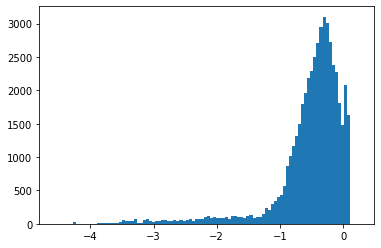

In [ ]:
plt.hist(data['formation_energy'],bins = 100);
# plt.xlim([-4,-3])

In [14]:
cifs = np.array(data['cifs'])
# nsites = data['nsites']
# cifs = np.array(mp_data['cif'])



## visualize 

In [ ]:
print(reals.shape,elementals.shape)

(48707, 7, 5) (48707, 5, 63)


In [ ]:
elementals_df = pd.DataFrame(elementals.reshape(-1,5*63))
elementals_df = elementals_df.fillna(0)
elementals = np.array(elementals_df).reshape((-1,5,63))

In [ ]:
latt_c = reals[:,0,:]
ang = reals[:,1,:]
period = reals[:,2:,0]
group = reals[:,2:,1]
coords = reals[:,2:,2:]
dummy_reals,coords = scale_reals(reals)

print(latt_c.max(),ang.max(),period.max(),group.max(),coords.max())
print(latt_c.min(),ang.min(),period.min(),group.min(),coords.min())

6.99941544 156.03838163 9.0 17.0 0.99999983
0.0 0.0 0.0 0.0 0.0


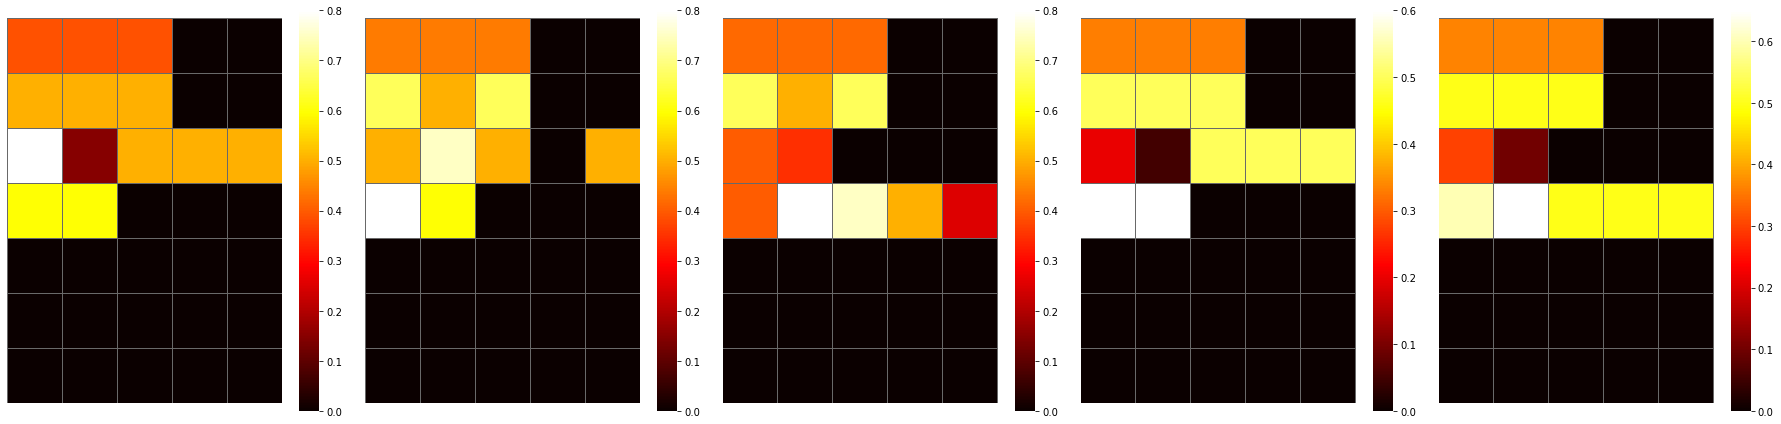

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 6))
for i in range(5):
    cax = sns.heatmap(dummy_reals[110+i].reshape((7,5)), cmap='hot',
                      linewidth=0.01, linecolor='dimgrey',
                     square=True, ax=ax[i])
    cax.axis('off')
plt.tight_layout()

## Combined Data

### regressor_

In [ ]:
# data_c = combined_data_from_cifs(cifs)
# y_data = np.array(data['formation_energy'])
## y_data = np.array(mp_data['formation_energy_per_atom'])
# print(y_data.max(),y_data.min())
# print(y_data.max(),y_data.min(),y_data.mean())

In [3]:
data_c = np.load('Combined_data/Janish/compressed_data.npz')['data_c']
y_data = np.load('Combined_data/Janish/compressed_data.npz')['y_data']
# np.savez_compressed('Combined_data/Janish/compressed_data.npz',y_data = y_data,data_c = data_c)

print(y_data.max(),y_data.min())
print(y_data.max(),y_data.min(),y_data.mean())

0.253750147583333 -4.5663778560874
0.253750147583333 -4.5663778560874 -0.5230497906535476


In [87]:
#only reals
data_c = data_c[:,:,:5]

In [ ]:
(0.0251/(0.2537 + 4.5663))*100

0.520746887966805

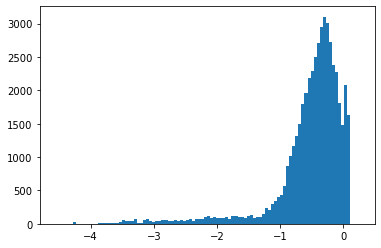

In [ ]:
plt.hist(y_data,bins = 100);

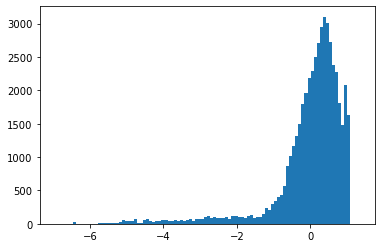

In [ ]:
plt.hist((y_data-y_data.mean())/y_data.std(),bins = 100);

In [88]:
x_train, x_test, y_train, y_test = train_test_split(data_c, y_data, test_size=0.20, random_state=42)
# y_label_train = np.int32(y_train<0)
# y_label_test = np.int32(y_test<0)

x_train = x_train.reshape((-1,7*data_c.shape[2]))
x_test = x_test.reshape((-1,7*data_c.shape[2]))

In [ ]:
pd.DataFrame(x_train[:,2:,5:].reshape((-1,5*63))).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314
count,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.00000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.000000,38965.0,38965.000000,38965.0,38965.0

In [ ]:
# x_train,y_train = oversample(x_train,y_train)
# print(x_train.shape)

(112045, 7, 68)
(112045, 7, 68)


In [89]:
#best scaling for inputs
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# best scaling for outputs
ymean = y_train.mean()
ystd = y_train.std()
y_train = (y_train-ymean)/ystd
y_test = (y_test-ymean)/ystd
print(y_test.min(),y_test.max(),ystd,ymean)

#filter all zero columns
filt = (x_train!=0).all(axis = 0)
x_train = ((x_train.T[filt]).T)
x_test = ((x_test.T[filt]).T)
print(x_train.shape)
m_ = x_train.shape[1]

-6.600453775275985 1.3311392052387696 0.5766398958308416 -0.5205147113119005
(38965, 31)


In [17]:
print(f'from {7*68}')
print('to ',filt.sum())
filt

from 476
to  280


array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [18]:
boru_filt = np.array([False,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False, False,  True,  True,
       False,  True, False, False,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True])
print(boru_filt.sum())
#user boruta_filter
# x_train = (x_train.T[boru_filt]).T
# x_test = (x_test.T[boru_filt]).T
# m_ = x_train.shape[1]
# print(x_train.shape)

237


In [19]:
combined_filt = []
filtmap = np.zeros(len(filt))
j = 0
for i in range(len(filt)):
    
    if filt[i]:
        if boru_filt[j]:
            combined_filt.append(True)
        else:
            combined_filt.append(False)
            filtmap[i] = -2
        j+=1
    else:
        combined_filt.append(False)
        filtmap[i] = -1
combined_filt = np.array(combined_filt)  
filtmap = filtmap.reshape(7,-1)
filtmap = (np.where(filt,1,0)+np.where(combined_filt,1,0)).reshape(7,-1)
%matplotlib notebook
sns.heatmap(filtmap)

In [4]:
# np.save('saved_model/column_filter.npy',filt)
# dump(scaler, 'saved_model/std_scaler.bin', compress=True)
#works
# sc=load('saved_model/std_scaler.bin')
ystd = 0.5766398958308416
ymean = -0.5205147113119005

In [90]:
def build_model2():
    
    inputs=tf.keras.Input(shape=(m_,1))
 
    x0 = tf.keras.layers.Flatten()(inputs)
    x=tf.keras.layers.Dense(512)(x0)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)

       
    x=tf.keras.layers.Concatenate()([x,x0])
    
    x=tf.keras.layers.Dense(2*256)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    
    x=tf.keras.layers.Concatenate()([x,x0])
    
    x=tf.keras.layers.Dense(128)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
#     
    x=tf.keras.layers.Concatenate()([x,x0])
    
    x=tf.keras.layers.Dense(64)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    
    
    x=tf.keras.layers.Dense(32)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    
    x=tf.keras.layers.Dense(8)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
#     x=tf.keras.layers.Dropout(0.1)(x)
    
    x=tf.keras.layers.Dense(4)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
#     x=tf.keras.layers.Dropout(0.1)(x)

    x=tf.keras.layers.Dense(1)(x)
#     x=tf.keras.layers.LeakyReLU()(x)
   
    
    model=tf.keras.Model(inputs=inputs,outputs= x)
    return model
"""
def build_model2():
    inputs = tf.keras.Input(shape=(m_,1))
    x0 = tf.keras.layers.Flatten()(inputs)

    x = tf.keras.layers.Dense(1024, activation='relu')(x0)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(8, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


def build_model_resnet():
    inputs = tf.keras.Input(shape=(m_, 1))
    x = tf.keras.layers.Reshape((m_,1))(inputs)
    # First Residual Block
    x0 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x0)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, x0])

    # Second Residual Block
    x0 = x
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, x0])

    # Output Layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model
"""
# model = build_model2()
#load the best model architecture
saved_model = tf.keras.models.load_model('saved_model/regressor_best')
model = tf.keras.models.clone_model(saved_model) #weights would be reinitialized
model.summary()
# model.layers()
# model.get_config()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 280, 1)]     0           []                               
                                                                                                  
 flatten_13 (Flatten)           (None, 280)          0           ['input_14[0][0]']               
                                                                                                  
 dense_102 (Dense)              (None, 512)          143872      ['flatten_13[0][0]']             
                                                                                                  
 batch_normalization_89 (BatchN  (None, 512)         2048        ['dense_102[0][0]']              
 ormalization)                                                                             

In [92]:
# # change the config to update the input layer according to the shape of the data
# model_config = model.get_config()
# input_layer_name = model_config['layers'][0]['name']
# model_config['layers'][0] = {
#                       'name': 'new_input',
#                       'class_name': 'InputLayer',
#                       'config': {
#                           'batch_input_shape': (None,m_,1),
#                           'dtype': 'float32',
#                           'sparse': False,
#                           'ragged': False,
#                           'name': 'new_input'
#                       },
#                       'inbound_nodes': []
#                   }
# model_config['layers'][1]['inbound_nodes'] = [[['new_input', 0, 0, {}]]]
# model_config['input_layers'] = [['new_input', 0, 0]]
# model = model.__class__.from_config(model_config, custom_objects={}) 


In [94]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 new_input (InputLayer)         [(None, 31, 1)]      0           []                               
                                                                                                  
 flatten_13 (Flatten)           (None, 31)           0           ['new_input[0][0]']              
                                                                                                  
 dense_102 (Dense)              (None, 512)          16384       ['flatten_13[0][0]']             
                                                                                                  
 batch_normalization_89 (BatchN  (None, 512)         2048        ['dense_102[0][0]']              
 ormalization)                                                                             

In [97]:
model.compile(
    
    optimizer=tf.keras.optimizers.Adam(),  
    loss = 'mse',
    metrics=['mae','mse']
)


In [98]:
filepath = 'saved_model/regressor_re_final'
cb = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=0,mode = 'min', save_best_only=True,save_weights_only=False, save_freq='epoch',)

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.1063 - mse: 0.019 - 2s 187ms/step - loss: 0.0199 - mae: 0.1063 - mse: 0.0199 - val_loss: 0.0485 - val_mae: 0.1367 - val_mse: 0.0485
Epoch 2/200
2/2 [==============================] - 0s 157ms/step - loss: 0.0198 - mae: 0.1060 - mse: 0.0198 - val_loss: 0.0481 - val_mae: 0.1362 - val_mse: 0.0481
Epoch 3/200
2/2 [==============================] - 0s 157ms/step - loss: 0.0194 - mae: 0.1054 - mse: 0.0194 - val_loss: 0.0485 - val_mae: 0.1366 - val_mse: 0.0485
Epoch 4/200
2/2 [==============================] - 0s 152ms/step - loss: 0.0196 - mae: 0.1056 - mse: 0.0196 - val_loss: 0.0483 - val_mae: 0.1361 - val_mse: 0.0483
Epoch 5/200
2/2 [==============================] - 0s 168ms/step - loss: 0.0195 - mae: 0.1055 - mse: 0.0195 - val_loss: 0.0485 - val_mae: 0.1364 - val_mse: 0.0485
Epoch 6/200
2/2 [==============================] - 0s 158ms/step - loss: 0.0192 - mae: 0.1050 - mse: 0.0192 - val_loss: 0.0491 - val_

Epoch 51/200
2/2 [==============================] - 0s 161ms/step - loss: 0.0193 - mae: 0.1049 - mse: 0.0193 - val_loss: 0.0485 - val_mae: 0.1363 - val_mse: 0.0485
Epoch 52/200
2/2 [==============================] - 0s 158ms/step - loss: 0.0190 - mae: 0.1041 - mse: 0.0190 - val_loss: 0.0489 - val_mae: 0.1367 - val_mse: 0.0489
Epoch 53/200
2/2 [==============================] - 0s 156ms/step - loss: 0.0193 - mae: 0.1042 - mse: 0.0193 - val_loss: 0.0498 - val_mae: 0.1372 - val_mse: 0.0498
Epoch 54/200
2/2 [==============================] - 0s 158ms/step - loss: 0.0191 - mae: 0.1047 - mse: 0.0191 - val_loss: 0.0498 - val_mae: 0.1371 - val_mse: 0.0498
Epoch 55/200
2/2 [==============================] - 0s 173ms/step - loss: 0.0194 - mae: 0.1052 - mse: 0.0194 - val_loss: 0.0492 - val_mae: 0.1363 - val_mse: 0.0492
Epoch 56/200
2/2 [==============================] - 0s 156ms/step - loss: 0.0194 - mae: 0.1052 - mse: 0.0194 - val_loss: 0.0482 - val_mae: 0.1355 - val_mse: 0.0482
Epoch 57/200
2/2

Epoch 100/200
2/2 [==============================] - 0s 159ms/step - loss: 0.0193 - mae: 0.1047 - mse: 0.0193 - val_loss: 0.0479 - val_mae: 0.1353 - val_mse: 0.0479
Epoch 101/200
2/2 [==============================] - 0s 159ms/step - loss: 0.0194 - mae: 0.1048 - mse: 0.0194 - val_loss: 0.0478 - val_mae: 0.1352 - val_mse: 0.0478
Epoch 102/200
2/2 [==============================] - 4s 4s/step - loss: 0.0193 - mae: 0.1044 - mse: 0.0193 - val_loss: 0.0474 - val_mae: 0.1348 - val_mse: 0.0474
Epoch 103/200
2/2 [==============================] - 0s 154ms/step - loss: 0.0192 - mae: 0.1049 - mse: 0.0192 - val_loss: 0.0481 - val_mae: 0.1353 - val_mse: 0.0481
Epoch 104/200
2/2 [==============================] - 0s 161ms/step - loss: 0.0192 - mae: 0.1043 - mse: 0.0192 - val_loss: 0.0484 - val_mae: 0.1355 - val_mse: 0.0484
Epoch 105/200
2/2 [==============================] - 4s 4s/step - loss: 0.0195 - mae: 0.1053 - mse: 0.0195 - val_loss: 0.0476 - val_mae: 0.1347 - val_mse: 0.0476
Epoch 106/200
2/

Epoch 147/200
2/2 [==============================] - 0s 170ms/step - loss: 0.0190 - mae: 0.1040 - mse: 0.0190 - val_loss: 0.0480 - val_mae: 0.1350 - val_mse: 0.0480
Epoch 148/200
2/2 [==============================] - 0s 166ms/step - loss: 0.0190 - mae: 0.1040 - mse: 0.0190 - val_loss: 0.0481 - val_mae: 0.1353 - val_mse: 0.0481
Epoch 149/200
2/2 [==============================] - 0s 172ms/step - loss: 0.0191 - mae: 0.1044 - mse: 0.0191 - val_loss: 0.0479 - val_mae: 0.1350 - val_mse: 0.0479
Epoch 150/200
2/2 [==============================] - 0s 162ms/step - loss: 0.0192 - mae: 0.1046 - mse: 0.0192 - val_loss: 0.0478 - val_mae: 0.1352 - val_mse: 0.0478
Epoch 151/200
2/2 [==============================] - 0s 161ms/step - loss: 0.0194 - mae: 0.1049 - mse: 0.0194 - val_loss: 0.0477 - val_mae: 0.1352 - val_mse: 0.0477
Epoch 152/200
2/2 [==============================] - 0s 169ms/step - loss: 0.0190 - mae: 0.1043 - mse: 0.0190 - val_loss: 0.0478 - val_mae: 0.1351 - val_mse: 0.0478
Epoch 153/

Epoch 194/200
2/2 [==============================] - 0s 168ms/step - loss: 0.0192 - mae: 0.1043 - mse: 0.0192 - val_loss: 0.0479 - val_mae: 0.1351 - val_mse: 0.0479
Epoch 195/200
2/2 [==============================] - 0s 185ms/step - loss: 0.0190 - mae: 0.1041 - mse: 0.0190 - val_loss: 0.0483 - val_mae: 0.1353 - val_mse: 0.0483
Epoch 196/200
2/2 [==============================] - 0s 166ms/step - loss: 0.0189 - mae: 0.1039 - mse: 0.0189 - val_loss: 0.0483 - val_mae: 0.1352 - val_mse: 0.0483
Epoch 197/200
2/2 [==============================] - 0s 175ms/step - loss: 0.0189 - mae: 0.1036 - mse: 0.0189 - val_loss: 0.0472 - val_mae: 0.1343 - val_mse: 0.0472
Epoch 198/200
2/2 [==============================] - 0s 181ms/step - loss: 0.0188 - mae: 0.1038 - mse: 0.0188 - val_loss: 0.0471 - val_mae: 0.1344 - val_mse: 0.0471
Epoch 199/200
2/2 [==============================] - 0s 180ms/step - loss: 0.0192 - mae: 0.1048 - mse: 0.0192 - val_loss: 0.0478 - val_mae: 0.1352 - val_mse: 0.0478
Epoch 200/

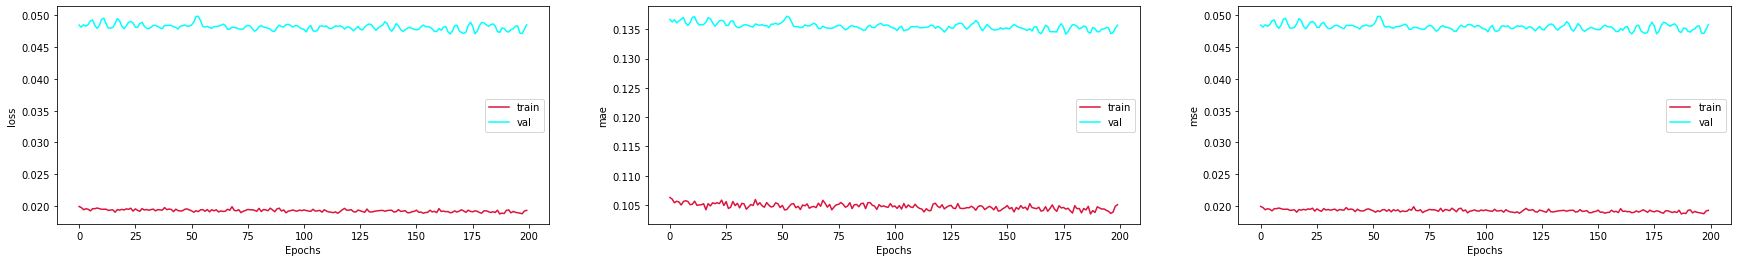

In [101]:
history = model.fit(x_train.reshape((-1,m_,1)), y_train,batch_size=20000,epochs=200,validation_split = 0.1,callbacks = [cb])
hist=history.history
idx = len(hist)//2
keys = list(hist.keys())
fig,ax=plt.subplots(1,idx,figsize=(30,4))
for i in range(idx):
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(keys[i])
    ax[i].plot(np.array(hist[keys[i]]).round(5),color='crimson',label = 'train')
    ax[i].plot(np.array(hist[keys[i+idx]]).round(5),color = 'cyan',label = 'val')
    ax[i].legend()


In [ ]:
#myrep = 0.026
#borutamyrep = 0.03
#atharva rep = 0.028
#only reals = 0.080

In [102]:
saved_model = tf.keras.models.load_model('saved_model/regressor_re_final')

In [103]:
print("Evaluate on test data")
results = model.evaluate(x_test.reshape((-1,m_,1)), y_test, batch_size=500)
print("test loss, test acc:", results)

Evaluate on test data
20/20 [==============================] - 0s 14ms/step - loss: 0.0523 - mae: 0.1419 - mse: 0.0523
test loss, test acc: [0.052262082695961, 0.14191104471683502, 0.052262082695961]


In [104]:
print("Evaluate on test data")
results = saved_model.evaluate(x_test.reshape((-1,m_,1)), y_test, batch_size=500)
print("test loss, test acc:", results)

Evaluate on test data
20/20 [==============================] - 0s 11ms/step - loss: 0.0506 - mae: 0.1403 - mse: 0.0506
test loss, test acc: [0.05059269815683365, 0.1402752846479416, 0.05059269815683365]


In [ ]:
model = tf.keras.models.clone_model(saved_model) #weights would be reinitialized

In [105]:
preds =saved_model.predict(x_test.reshape((-1,m_,1)))*ystd +ymean
np.abs((preds.flatten() - (y_test*ystd +ymean))).mean()

0.08088833180603787

In [ ]:
# 1300 epochs with 500 batch size then 200 epochs with 10000 batch size then 100 epochs for 20000 batch 0.0251 mae

0.03041406527243686

In [ ]:
#mp_data nsites <6 Regression, train on 9763 for 300 epochs, loss: 0.0109 - mae: 0.0699
#oqmd data nsites<6 Regression train on 9763 for 300 epochs, loss: 0.0080 - mae: 0.0609 

#Evaluate on test data without propdata
#loss: 0.1155 - mae: 0.0574 - accuracy: 0.9602 - mse: 0.0315 - precision_2: 0.9606 - recall_2: 0.9972 - auc_2: 0.9596

#Evaluate on test data with propdata
#loss: 0.0597 - mae: 0.0277 - accuracy: 0.9800 - mse: 0.0161 - precision: 0.9813 - recall: 0.9970 

### Regressor_Atharva

In [62]:
from  OHE_Rep_Atharva import get_ohe_representation as gor

In [64]:
# data_c = np.zeros((len(cifs),21,128))
# for i,cif in enumerate(cifs):
#     data_c[i] = gor(cif,json_path)

# y_data = np.array(data['formation_energy'])
data_c = np.load('Combined_data\Atharva\data_c_regress2.npy')
y_data = np.load('Combined_data\Atharva\y_data_regress2.npy')

print(y_data.max(),y_data.min())
print(y_data.max(),y_data.min(),y_data.mean())

x_train, x_test, y_train, y_test = train_test_split(data_c, y_data, test_size=0.20, random_state=42)
# y_label_train = np.int32(y_train<0)
# y_label_test = np.int32(y_test<0)

x_train = x_train.reshape((-1,21*128))
x_test = x_test.reshape((-1,21*128))

#best scaling for inputs
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# best scaling for outputs
ymean = y_train.mean()
ystd = y_train.std()
y_train = (y_train-ymean)/ystd
y_test = (y_test-ymean)/ystd
print(y_test.min(),y_test.max(),ystd,ymean)

#filter all zero columns
filt = (x_train!=0).all(axis = 0)
x_train = ((x_train.T[filt]).T)
x_test = ((x_test.T[filt]).T)
print(x_train.shape)

0.253750147583333 -4.5663778560874
0.253750147583333 -4.5663778560874 -0.5230497906535476
-6.600453775275985 1.3311392052387696 0.5766398958308416 -0.5205147113119005
(38965, 582)


In [ ]:

def conv1d_block(channels,kernel,strides,pool,padding = 'valid'):
    
    lays = [tf.keras.layers.Conv1D(channels,kernel,strides=strides,padding = padding),
            tf.keras.layers.LeakyReLU(),tf.keras.layers.BatchNormalization()]
    
    if pool!= False:
        lays.append(tf.keras.layers.MaxPool1D(pool_size=pool))
        
    model = keras.Sequential(lays)
    return model

In [65]:

def build_model2():
    
    inputs=tf.keras.Input(shape=(582,1))
    
#     x0 = conv1d_block(8,3,1,3)(inputs)
#     x0 = conv1d_block(16,3,1,3)(x0)
#     x0 = conv1d_block(32,3,1,4)(x0)
#     x0 = conv1d_block(90,3,1,4)(x0)
  
    x0 = tf.keras.layers.Flatten()(inputs)
    x=tf.keras.layers.Dense(256)(x0)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.5)(x)

       
    x=tf.keras.layers.Concatenate()([x,x0])
    
    x=tf.keras.layers.Dense(256)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    
    x=tf.keras.layers.Concatenate()([x,x0])
    
    x=tf.keras.layers.Dense(128)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    
    x=tf.keras.layers.Concatenate()([x,x0])
    
    x=tf.keras.layers.Dense(64)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    
    
    x=tf.keras.layers.Dense(32)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    
    x=tf.keras.layers.Dense(8)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    
    x=tf.keras.layers.Dense(4)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
#     x=tf.keras.layers.Dropout(0.1)(x)

    x=tf.keras.layers.Dense(1)(x)
#     x=tf.keras.layers.LeakyReLU()(x)
   
    
    model=tf.keras.Model(inputs=inputs,outputs= x)
    return model

# model = build_model2()
saved_model = tf.keras.models.load_model('saved_model/regressor_best')
model = tf.keras.models.clone_model(saved_model) #weights would be reinitialized


model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 280, 1)]     0           []                               
                                                                                                  
 flatten_13 (Flatten)           (None, 280)          0           ['input_14[0][0]']               
                                                                                                  
 dense_102 (Dense)              (None, 512)          143872      ['flatten_13[0][0]']             
                                                                                                  
 batch_normalization_89 (BatchN  (None, 512)         2048        ['dense_102[0][0]']              
 ormalization)                                                                             

In [66]:
model_config = model.get_config()
input_layer_name = model_config['layers'][0]['name']

model_config['layers'][0] = {
                      'name': 'new_input',
                      'class_name': 'InputLayer',
                      'config': {
                          'batch_input_shape': (None,582,1),
                          'dtype': 'float32',
                          'sparse': False,
                          'ragged': False,
                          'name': 'new_input'
                      },
                      'inbound_nodes': []
                  }
model_config['layers'][1]['inbound_nodes'] = [[['new_input', 0, 0, {}]]]
model_config['input_layers'] = [['new_input', 0, 0]]
new_model = model.__class__.from_config(model_config, custom_objects={}) 

In [69]:
# model = new_model
model.compile(
    
    optimizer=tf.keras.optimizers.Adam(),  
    loss = 'mse',
    metrics=['mae','mse']#'accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()]
)

filepath = 'saved_model/regressor2'
cb = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=0,mode = 'min', save_best_only=True,save_weights_only=False, save_freq='epoch',)

Epoch 1/200
4/4 [==============================] - 3s 277ms/step - loss: 0.0038 - mae: 0.0418 - mse: 0.0038 - val_loss: 0.0088 - val_mae: 0.0523 - val_mse: 0.0088
Epoch 2/200
4/4 [==============================] - 1s 137ms/step - loss: 0.0032 - mae: 0.0392 - mse: 0.0032 - val_loss: 0.0092 - val_mae: 0.0531 - val_mse: 0.0092
Epoch 3/200
4/4 [==============================] - 1s 136ms/step - loss: 0.0030 - mae: 0.0374 - mse: 0.0030 - val_loss: 0.0087 - val_mae: 0.0517 - val_mse: 0.0087
Epoch 4/200
4/4 [==============================] - 1s 136ms/step - loss: 0.0028 - mae: 0.0370 - mse: 0.0028 - val_loss: 0.0085 - val_mae: 0.0511 - val_mse: 0.0085
Epoch 5/200
4/4 [==============================] - 1s 135ms/step - loss: 0.0027 - mae: 0.0363 - mse: 0.0027 - val_loss: 0.0088 - val_mae: 0.0516 - val_mse: 0.0088
Epoch 6/200
4/4 [==============================] - 1s 141ms/step - loss: 0.0027 - mae: 0.0363 - mse: 0.0027 - val_loss: 0.0089 - val_mae: 0.0532 - val_mse: 0.0089
Epoch 7/200
4/4 [=====

4/4 [==============================] - 1s 149ms/step - loss: 0.0025 - mae: 0.0344 - mse: 0.0025 - val_loss: 0.0112 - val_mae: 0.0587 - val_mse: 0.0112
Epoch 52/200
4/4 [==============================] - 1s 149ms/step - loss: 0.0024 - mae: 0.0342 - mse: 0.0024 - val_loss: 0.0114 - val_mae: 0.0598 - val_mse: 0.0114
Epoch 53/200
4/4 [==============================] - 1s 149ms/step - loss: 0.0024 - mae: 0.0343 - mse: 0.0024 - val_loss: 0.0115 - val_mae: 0.0592 - val_mse: 0.0115
Epoch 54/200
4/4 [==============================] - 1s 149ms/step - loss: 0.0024 - mae: 0.0341 - mse: 0.0024 - val_loss: 0.0104 - val_mae: 0.0572 - val_mse: 0.0104
Epoch 55/200
4/4 [==============================] - 1s 150ms/step - loss: 0.0024 - mae: 0.0346 - mse: 0.0024 - val_loss: 0.0118 - val_mae: 0.0617 - val_mse: 0.0118
Epoch 56/200
4/4 [==============================] - 1s 150ms/step - loss: 0.0024 - mae: 0.0342 - mse: 0.0024 - val_loss: 0.0098 - val_mae: 0.0564 - val_mse: 0.0098
Epoch 57/200
4/4 [===========

4/4 [==============================] - 1s 170ms/step - loss: 0.0024 - mae: 0.0336 - mse: 0.0024 - val_loss: 0.0103 - val_mae: 0.0558 - val_mse: 0.0103
Epoch 102/200
4/4 [==============================] - 1s 157ms/step - loss: 0.0023 - mae: 0.0337 - mse: 0.0023 - val_loss: 0.0100 - val_mae: 0.0555 - val_mse: 0.0100
Epoch 103/200
4/4 [==============================] - 1s 147ms/step - loss: 0.0024 - mae: 0.0341 - mse: 0.0024 - val_loss: 0.0108 - val_mae: 0.0592 - val_mse: 0.0108
Epoch 104/200
4/4 [==============================] - 1s 148ms/step - loss: 0.0024 - mae: 0.0339 - mse: 0.0024 - val_loss: 0.0099 - val_mae: 0.0563 - val_mse: 0.0099
Epoch 105/200
4/4 [==============================] - 1s 149ms/step - loss: 0.0023 - mae: 0.0335 - mse: 0.0023 - val_loss: 0.0112 - val_mae: 0.0565 - val_mse: 0.0112
Epoch 106/200
4/4 [==============================] - 1s 161ms/step - loss: 0.0024 - mae: 0.0342 - mse: 0.0024 - val_loss: 0.0102 - val_mae: 0.0571 - val_mse: 0.0102
Epoch 107/200
4/4 [=====

Epoch 151/200
4/4 [==============================] - 1s 152ms/step - loss: 0.0024 - mae: 0.0336 - mse: 0.0024 - val_loss: 0.0096 - val_mae: 0.0536 - val_mse: 0.0096
Epoch 152/200
4/4 [==============================] - 1s 155ms/step - loss: 0.0023 - mae: 0.0334 - mse: 0.0023 - val_loss: 0.0113 - val_mae: 0.0583 - val_mse: 0.0113
Epoch 153/200
4/4 [==============================] - 1s 154ms/step - loss: 0.0024 - mae: 0.0337 - mse: 0.0024 - val_loss: 0.0103 - val_mae: 0.0584 - val_mse: 0.0103
Epoch 154/200
4/4 [==============================] - 1s 154ms/step - loss: 0.0022 - mae: 0.0329 - mse: 0.0022 - val_loss: 0.0108 - val_mae: 0.0560 - val_mse: 0.0108
Epoch 155/200
4/4 [==============================] - 1s 152ms/step - loss: 0.0024 - mae: 0.0334 - mse: 0.0024 - val_loss: 0.0103 - val_mae: 0.0551 - val_mse: 0.0103
Epoch 156/200
4/4 [==============================] - 1s 152ms/step - loss: 0.0024 - mae: 0.0339 - mse: 0.0024 - val_loss: 0.0101 - val_mae: 0.0558 - val_mse: 0.0101
Epoch 157/

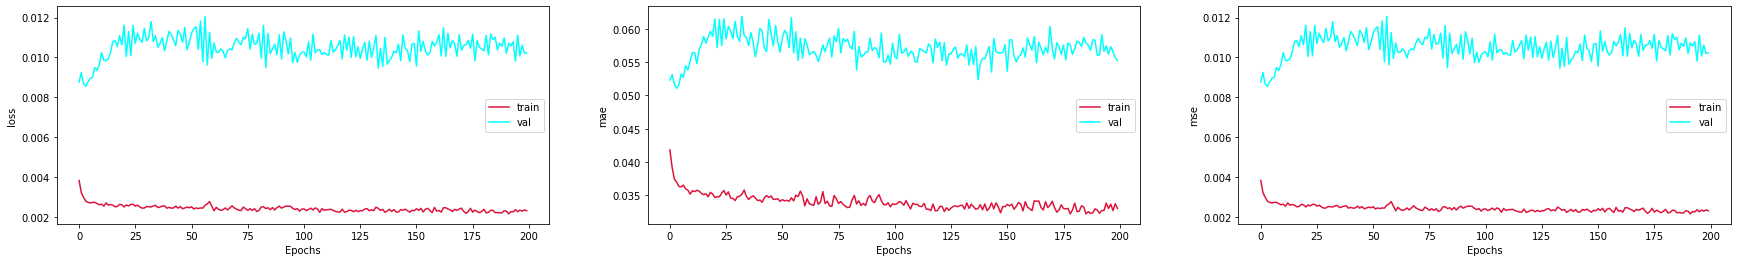

In [73]:
history = model.fit(x_train.reshape((-1,582,1)), y_train,batch_size=20000,epochs=200,validation_split = 0.1,callbacks = [cb])
hist=history.history
idx = len(hist)//2
keys = list(hist.keys())
fig,ax=plt.subplots(1,idx,figsize=(30,4))
for i in range(idx):
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(keys[i])
    ax[i].plot(np.array(hist[keys[i]]).round(5),color='crimson',label = 'train')
    ax[i].plot(np.array(hist[keys[i+idx]]).round(5),color = 'cyan',label = 'val')
    ax[i].legend()

In [ ]:
#can be important in future
batch_epochs = [(500,1300),(10000,100),(20000,100)]
batch_epochs = [(500,13),(10000,10),(20000,10)]
frames = []
for (batch_sz,epochs) in batch_epochs:

    history = model.fit(x_train.reshape((-1,582,1)), y_train,batch_size=batch_sz,epochs=epochs,validation_split = 0.1,call_backs = [cb])
    hist=history.history
    idx = len(hist)//2
    keys = list(hist.keys())
    
    frame = pd.DataFrame(np.arange(epochs).reshape((-1,1)),columns = ['epochs'])
    for i in range(idx):
           
        aa = np.array(hist[keys[i]]).round(5)
        bb = np.array(hist[keys[i+idx]]).round(5)
        aa = aa.reshape((-1,1))
        bb = bb.reshape((-1,1))
        
        dat = pd.DataFrame(np.concatenate((aa,bb),axis = 1),columns = [keys[i],keys[i+idx]])
        frame = pd.concat([frame,dat],axis = 1)
    frames.append(frame)
train_res = pd.concat(frames,axis = 0)


Epoch 1/13
71/71 [==============================] - 2s 24ms/step - loss: 0.1262 - mae: 0.1262 - mse: 0.0470 - val_loss: 0.0840 - val_mae: 0.0840 - val_mse: 0.0175
Epoch 2/13
71/71 [==============================] - 2s 24ms/step - loss: 0.1230 - mae: 0.1230 - mse: 0.0460 - val_loss: 0.0821 - val_mae: 0.0821 - val_mse: 0.0166
Epoch 3/13
71/71 [==============================] - 2s 23ms/step - loss: 0.1276 - mae: 0.1276 - mse: 0.0509 - val_loss: 0.0825 - val_mae: 0.0825 - val_mse: 0.0165
Epoch 4/13
71/71 [==============================] - 2s 24ms/step - loss: 0.1269 - mae: 0.1269 - mse: 0.0504 - val_loss: 0.0829 - val_mae: 0.0829 - val_mse: 0.0166
Epoch 5/13
71/71 [==============================] - 2s 28ms/step - loss: 0.1269 - mae: 0.1269 - mse: 0.0501 - val_loss: 0.0825 - val_mae: 0.0825 - val_mse: 0.0161
Epoch 6/13
71/71 [==============================] - 2s 30ms/step - loss: 0.1277 - mae: 0.1277 - mse: 0.0494 - val_loss: 0.0902 - val_mae: 0.0902 - val_mse: 0.0208
Epoch 7/13
71/71 [====

,epochs,loss,valval_loss,mae,valval_mae,mse,valval_mse
0,0,0.12625,0.08401,0.12625,0.08401,0.04698,0.01750
1,1,0.12305,0.08209,0.12305,0.08209,0.04597,0.01659
2,2,0.12764,0.08249,0.12764,0.08249,0.05094,0.01653
3,3,0.12685,0.08287,0.12685,0.08287,0.05038,0.01656
4,4,0.12685,0.08250,0.12685,0.08250,0.05013,0.01611
5,5,0.12768,0.09019,0.12768,0.09019,0.04939,0.02078
6,6,0.12605,0.07813,0.12605,0.07813,0.04940,0.01539
7,7,0.12645,0.08155,0.12645,0.08155,0.04963,0.01714
8,8,0.12490,0.07921,0.12490,0.07921,0.04891,0.01608
9,9,0.12627,0.07979,0.12627,0.07979,0.05061,0.01648


In [74]:
model = tf.keras.models.load_model('saved_model/regressor2')

In [75]:
preds =model.predict(x_test.reshape((-1,582,1)))*ystd +ymean
test_mae = np.abs((preds.flatten() - (y_test*ystd +ymean))).mean()
print(test_mae)

0.028058453032274028


In [ ]:
res = pd.read_csv('combined_data/Atharva/train_res.csv')
res

,epochs,loss,val_loss,mae,val_mae,mse,val_mse
0,0,0.45054,0.79829,0.45054,0.79829,0.46344,2.88604
1,1,0.27831,0.32954,0.27831,0.32954,0.19003,0.40377
2,2,0.23346,0.19365,0.23346,0.19365,0.13555,0.11475
3,3,0.21425,0.17345,0.21425,0.17345,0.11708,0.08096
4,4,0.20207,0.16038,0.20207,0.16038,0.10348,0.07052
...,...,...,...,...,...,...,...
1495,95,0.06904,0.10909,0.06904,0.10909,0.01369,0.02676
1496,96,0.06876,0.10900,0.06876,0.10900,0.01317,0.02679
1497,97,0.06869,0.10875,0.06869,0.10875,0.01366,0.02672
1498,98,0.06904,0.10838,0.06904,0.10838,0.01408,0.02653


# Analysis

In [8]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)
import matplotlib
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import ipywidgets as widgets
from ipywidgets import interact,interactive, interact_manual
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import simpson

## ratios

In [9]:
#requires elements file
def get_element(x):
    try:
        m=elements[(elements['row']==x[0])&(elements['group']==x[1])]['Element'].values[0]
    except:
        m=np.nan
    return m

def get_atomics(period_group):
    atomics = np.zeros(len(period_group))
    for i in np.arange(len(period_group)):
        ele = get_element(period_group[i])
        a = elements[elements['Element'] == ele]['atomic_number'].values[0]
        atomics[i] = a
    return atomics
#requires pymatgen
def give_probs(cifs):
    atomic_ns = []
    ele_probs = np.zeros(120)

    for i,cif in enumerate(cifs):

        struct=Structure.from_str(cif,'cif')
        species=np.array(struct.species).reshape(-1,1)
        period_group=np.hstack(vectorise(species))
        atomics = get_atomics(period_group)
        atomic_ns.append(atomics)
        val,freq = np.unique(atomics,return_counts = True)
        val = np.array(val,dtype = np.int32)
        ele_probs[val] += freq/freq.sum()

    ele_probs = ele_probs/len(cifs)
    return ele_probs

def prob_to_periodic_table(ele_probs):
    periodic_table = np.zeros((10,19))
    
    for i,prob in enumerate(ele_probs[:118]):
        if prob != 0 :
            aa = elements[elements['atomic_number'] == i]
            p = int(aa['row'].values[0])
            g = int(aa['group'].values[0])
            periodic_table[p-1,g-1] = prob
    return periodic_table

def give_periodic_table(data,threshold,win = False):
    
    if win is False:
        filt = data['formation_energy']<threshold
    else:
        filt = ((data['formation_energy']<(threshold+win/2)) & (data['formation_energy']>(threshold-win/2)))
    
    cifs = np.array(data[filt]['cifs'])
    ele_probs = give_probs(cifs)
    return prob_to_periodic_table(ele_probs)

# samples in folder new_samples
def process_cif_files(root):
    
    cif_names = os.listdir(root)
    cifs = []
    for name in cif_names:
        path = root+'/'+name
        f = open(path, "r")
        cifs.append(f.read())

    samples=[]
    new_cif_names = []
    badcifs = []
    for j,i in enumerate(cifs):
        try:
            samples.append(combined_data_from_cifs([i]))
            new_cif_names.append(cif_names[j])
        except: 
            badcifs.append([i,cif_names[j]])
            if os.path.exists(root+'/'+cif_names[j]):
                os.remove(root+'/'+cif_names[j])

    x_samples= np.array(samples).reshape((-1,7,68))
    x_samples = x_samples.reshape((-1,7*68))
    x_samples = scaler.transform(x_samples)
    x_samples = ((x_samples.T[filt]).T)
    print(len(badcifs))
    return x_samples,cifs

In [11]:
#removed 25 bad cifs from unstable
#removed 37 bad cifs from new stable generation
root1 = 'data_prob/probabilityElementUnStable'
prob_unstable,cif_unstable = process_cif_files(root1)
root2 = 'data_prob/probabilityElementStable'
prob_stable,cif_stable = process_cif_files(root2)

0
0


In [8]:
# saved_model = tf.keras.models.load_model('saved_model/regressor_best')
# fe_stable = saved_model.predict(prob_stable)*ystd +ymean
# fe_unstable = saved_model.predict(prob_unstable)*ystd +ymean
# data_stable = pd.DataFrame(fe_stable,columns = ['formation_energy'])
# data_stable['cifs'] = np.array(cif_stable).reshape((-1,1))
# data_unstable = pd.DataFrame(fe_unstable,columns = ['formation_energy'])
# data_unstable['cifs'] = np.array(cif_unstable).reshape((-1,1))
data_stable = pd.read_csv('predicted_FE_stable.csv')
data_unstable = pd.read_csv('predicted_FE_unstable.csv')
fe_stable = np.array(data_stable['formation_energy'])
fe_unstable = np.array(data_unstable['formation_energy'])

lanact_filt = np.zeros(len(data_c),dtype = np.bool)
for i in range(len(data_c)):
    lanact_filt[i] = (not (data_c[i][2:,:1]>0.6).any())
    
fe_st_w = (fe_stable.max() - fe_stable.min())/200
fe_unst_w = (fe_unstable.max() - fe_unstable.min())/200
fe_data = np.array(data[lanact_filt]['formation_energy'])
fe_data_w = (fe_data.max()-fe_data.min())/200
xlim = [min(fe_data.min(),fe_stable.min(),fe_unstable.min()),max(fe_data.max(),fe_stable.max(),fe_unstable.max())]

In [9]:
data[lanact_filt]

,cifs,stability,formation_energy,nsites,nelements,elements,remove_unwanted
2,# generated using pymatgen\ndata_ZnNi\n_symmet...,0.000000,-0.262073,2,2,"['Ni', 'Zn']",0
3,# generated using pymatgen\ndata_ZnNi\n_symmet...,0.012330,-0.249743,2,2,"['Ni', 'Zn']",0
7,# generated using pymatgen\ndata_YAg\n_symmetr...,0.001558,-0.343094,2,2,"['Ag', 'Y']",0
8,# generated using pymatgen\ndata_LiBi\n_symmet...,0.000175,-0.387425,2,2,"['Bi', 'Li']",0
9,# generated using pymatgen\ndata_LiTl\n_symmet...,0.000088,-0.233202,2,2,"['Tl', 'Li']",0
...,...,...,...,...,...,...,...
48686,# generated using pymatgen\ndata_Cu2AgSe2\n_sy...,0.035434,-0.088712,5,3,"['Se', 'Cu', 'Ag']",0
48687,# generated using pymatgen\ndata_Cu2SnSe2\n_sy...,0.097892,-0.191258,5,3,"['Sn', 'Se', 'Cu']",0
48701,# generated using pymatgen\ndata_SbTeCl\n_symm...,0.000000,-0.592030,3,3,"['Cl', 'Sb', 'Te']",0
48702,# generated using pymatgen\ndata_LiAsSe2\n_sym...,0.029229,-0.537306,4,3,"['As', 'Se', 'Li']",0


(-4.26983361059833, 0.32044)

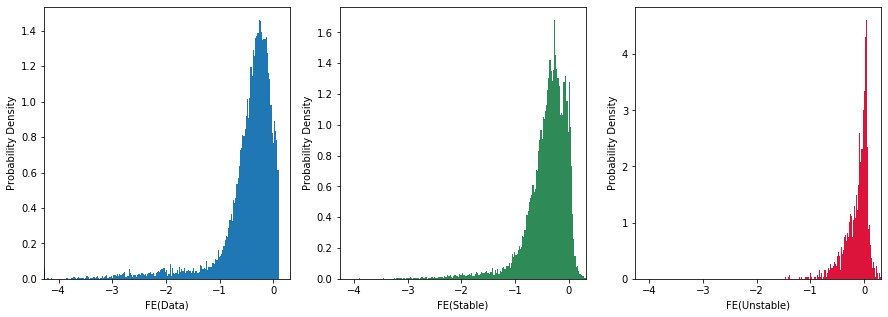

In [10]:
fig,axs = plt.subplots(1,3,figsize = (15,5),sharex = True)

(a,b,_) = axs[0].hist(fe_data,bins = 200,density = True);
axs[0].set_xlabel('FE(Data)')
axs[0].set_ylabel('Probability Density')

(a1,b1,_) = axs[1].hist(fe_stable,bins = 200,density = True,color = 'seagreen');
axs[1].set_xlabel('FE(Stable)')
axs[1].set_ylabel('Probability Density')

(a2,b2,_) = axs[2].hist(fe_unstable,bins = 200,density = True,color = 'crimson');
axs[2].set_xlabel('FE(Unstable)')
axs[2].set_ylabel('Probability Density')
plt.xlim(xlim)

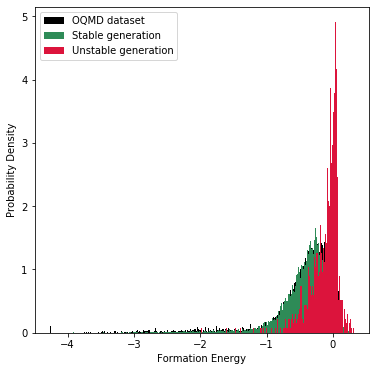

In [45]:
fig,ax = plt.subplots(1,1,figsize = (6,6))
alpha = 1
(a,b,_) =ax.hist(fe_data,bins = 400,density = True,color = 'black',alpha = 1,label = 'OQMD dataset');
(a1,b1,_) = ax.hist(fe_stable,bins = 400,density = True,color = 'seagreen',alpha = alpha,label = 'Stable generation');
(a2,b2,_) = ax.hist(fe_unstable,bins = 400,density = True,color = 'crimson',alpha = alpha,label = 'Unstable generation');
ax.set_xlabel('Formation Energy')
ax.set_ylabel('Probability Density')
plt.legend()
plt.savefig('plots/FE_Distros.svg',format = 'svg',dpi = 300)

In [12]:
avg_n = 3
def mov_avg(x, w):
    return np.convolve(x, np.ones(w), 'same') / w


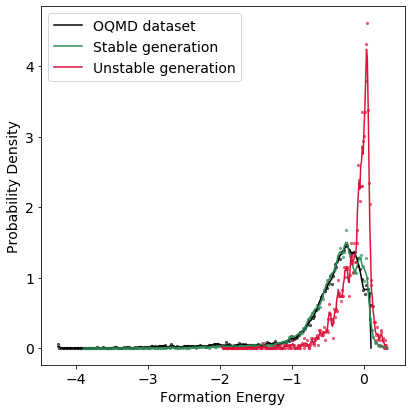

In [16]:
fig,ax = plt.subplots(1,1,figsize = (6,6))
alpha = 0.6
s = 5
lw = 1.5
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend',fontsize=14)
ax.scatter(b[1:],a,s = s,color = 'black',alpha = alpha);
a_ = mov_avg(a,3)
a_[-1] = 0
ax.plot(b[1:],a_,color = 'black',lw = lw,label = 'OQMD dataset')
ax.scatter(b1[1:],a1,s = s,color = 'seagreen',alpha = alpha);
ax.plot(b1[1:],mov_avg(a1,avg_n),color = 'seagreen',lw = lw,label = 'Stable generation')
ax.scatter(b2[1:],a2,s = s,color = 'crimson',alpha = alpha);
ax.plot(b2[1:],mov_avg(a2,avg_n),color = 'crimson',lw = lw,label = 'Unstable generation')
ax.set_xlabel('Formation Energy')
ax.set_ylabel('Probability Density')
plt.legend()
plt.tight_layout()
plt.savefig('plots/Figure_6.png',format = 'png',dpi = 300)


<IPython.core.display.Javascript object>


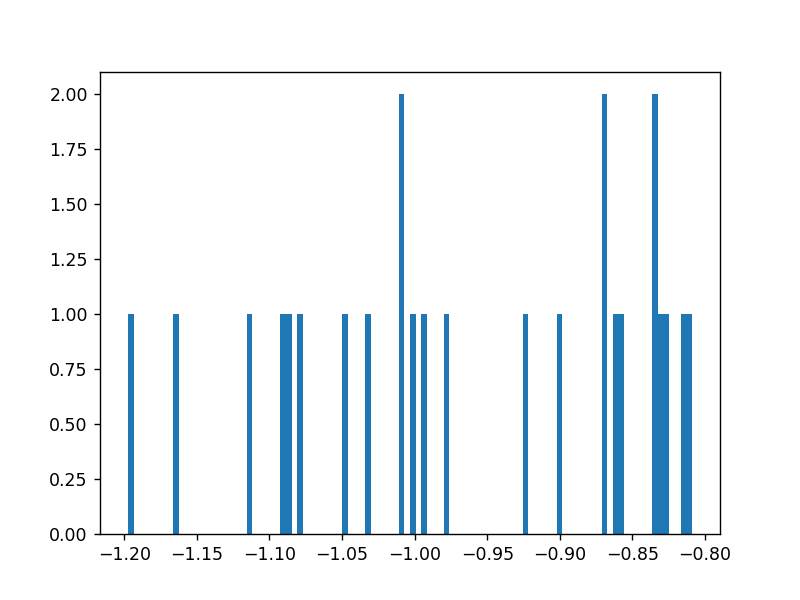

In [ ]:
th = -1
win = 0.4
arr = data_unstable['formation_energy']
filt = ((arr<(th+win/2)) & (arr>(th-win/2)))
plt.hist(data_unstable[filt]['formation_energy'],bins = 100);

In [67]:
ths = [[0,0.4],[-0.5,0.4]]


In [ ]:
import time
periodic_tables = np.zeros((3,3,10,19))
win = 0.5
i = 0
for th,win in ths:
    
    table_data = give_periodic_table(data[lanact_filt],th,win)
    table_st = give_periodic_table(data_stable,th,win)
    table_unst = give_periodic_table(data_unstable,th,win)
    
    periodic_tables[0,i] = table_data
    periodic_tables[1,i] = table_st
    periodic_tables[2,i] = table_unst
    i+=1

np.savez_compressed('periodic_tables_0.4win_comparision_moredata_without_lanact.npz',periodic_tables)

In [69]:
periodic_tables = np.load('periodic_tables_0.4win_comparision_moredata_without_lanact.npz')['arr_0']

In [70]:
periodic_tables.shape

(3, 3, 10, 19)

In [ ]:
#to start from 1 not 0 in the plot
# periodic_tables = np.concatenate((np.zeros((3,3,10,1)),periodic_tables),axis = 3)
# periodic_tables = np.concatenate((np.zeros((3,3,1,20)),periodic_tables),axis = 2)
periodic_tables[0,1:-1] = 1

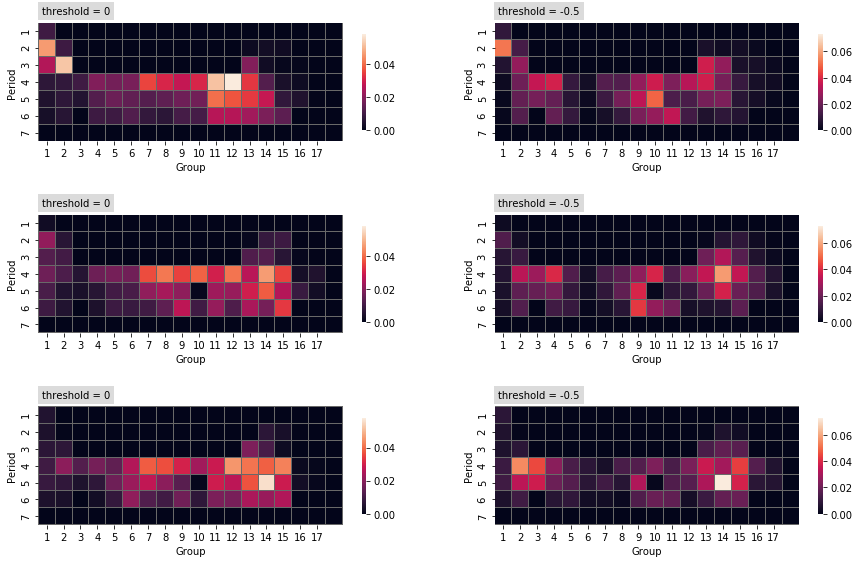

In [91]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
p_labels = list(range(1,8))
g_labels = list(range(1,18))
for i in range(3):
    for j in range(2):
        
        cax = sns.heatmap(periodic_tables[i,j],xticklabels = g_labels,yticklabels = p_labels,
                          vmin = 0,vmax = periodic_tables[:,j].max(),square = True,
                          linewidth=0.01, linecolor='dimgrey',ax = ax[i,j],cbar_kws={"shrink": .6})
        ax[i,j].text(x = 0.2,
                 y= -0.5,
                 s=f'threshold = {round(ths[j][0],3)}',
                 fontdict=dict(color='black',size=10),
                 bbox=dict(facecolor='lightgrey',edgecolor='none',alpha=0.8))
        ax[i,j].set_xlim([0,18])
        ax[i,j].set_ylim([7,0])
        ax[i,j].set_xlabel('Group')
        ax[i,j].set_ylabel('Period')
        
# plt.tight_layout()
plt.savefig('9by9periodictable_gridwith_rows_for_different_moredata_without_lanact.png',format = 'png', dpi = 600)

In [ ]:
import time
periodic_tables = np.zeros((48,10,19))
win = 0.5
for i,th in enumerate(np.arange(-4.5,0.25,0.1)):
    
    table = give_periodic_table(data,th,win)
    periodic_tables[i] = table

        
np.save('periodic_tables_0.5window.npy',periodic_tables)

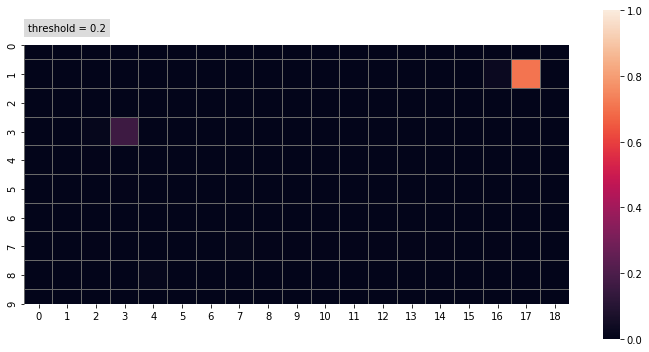

In [ ]:
#single plot
#cmap = 'YlGnBu','hot'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cax = sns.heatmap(periodic_table,vmin = 0,square = True,linewidth=0.01, linecolor='dimgrey',ax = ax)
ax.text(x = 0.14,
         y= 0,
         s=f'threshold = {round(th,3)}',
         fontdict=dict(color='black',size=10),
         bbox=dict(facecolor='lightgrey',edgecolor='none',alpha=0.8))
plt.tight_layout()

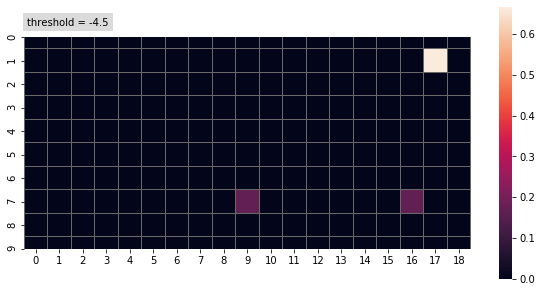

In [ ]:

#anime
ths = np.arange(-4.5,0.25,0.1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax = sns.heatmap(periodic_tables[0],vmin = 0,square = True,linewidth=0.01, linecolor='dimgrey')
# ax.text(x = 0.14,
#          y= 0,
#          s=f'threshold = {round(ths[0],3)}',
#          fontdict=dict(color='black',size=10),
#          bbox=dict(facecolor='lightgrey',edgecolor='none',alpha=0.8))


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

def init():
    plt.clf()
    ax = sns.heatmap(periodic_tables[0],vmin = 0,square = True,linewidth=0.01, linecolor='dimgrey')
    ax.text(x = 0.14,
         y= 0,
         s=f'threshold = {round(ths[0],3)}',
         fontdict=dict(color='black',size=10),
         bbox=dict(facecolor='lightgrey',edgecolor='none',alpha=0.8))


def animate(i):
    plt.clf()
    ax = sns.heatmap(periodic_tables[i],vmin = 0,square = True,linewidth=0.01, linecolor='dimgrey')
    ax.text(x = 0.14,
         y= 0,
         s=f'threshold = {round(ths[i],3)}',
         fontdict=dict(color='black',size=10),
         bbox=dict(facecolor='lightgrey',edgecolor='none',alpha=0.8))


anim = animation.FuncAnimation(fig, animate, init_func=init,frames = len(periodic_tables), interval=1000,blit = False)
# anim

anim.save('probabilites.mp4', writer=writer)


## residue

In [ ]:
preds =(saved_model.predict(x_test.reshape((-1,280,1)))*ystd +ymean).flatten()
residuals = (y_test*ystd +ymean).flatten() - preds

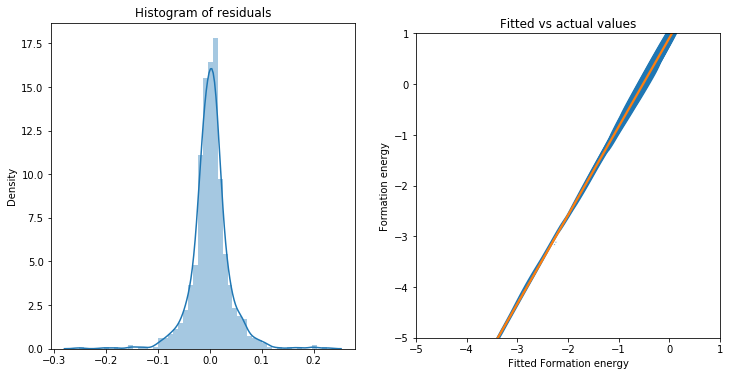

In [ ]:
# Two plots
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,6))

# 1. Histogram of residuals
sns.distplot(residuals[:1000], ax=ax1)
ax1.set_title('Histogram of residuals')

# Fitted vs residuals
x1 = pd.Series(preds[:1000], name='Fitted Formation energy')
x2 = pd.Series(y_test[:1000], name="Formation energy")
sns.kdeplot(x1, x2, n_levels=50,ax = ax2)
sns.regplot(x=x1,y=x2, scatter=False, ax = ax2)
ax2.set_title('Fitted vs actual values')
ax2.set_xlim([-5,1])
ax2.set_ylim([-5,1])
ax2.set_aspect('equal')

# permutation importance

In [ ]:
x_test_ = np.copy(x_test)


In [ ]:
x = np.arange(280)
latt_const_i = x[:3]
latt_ang_i = x[3:6]
row1_i = x[6:11]
prop1_i = x[11:6+68]
row2_i = x[6+68:11+68]
prop2_i = x[11+68:6+68*2]
row3_i = x[6+68*2:11+68*2]
prop3_i = x[11+68*2:6+68*3]
row4_i = x[6+68*3:11+68*3]
prop4_i = x[11+68*3:-5]
row5_i = x[-5:]
prop4_prob_idx = [5*68 +32,5*68+34,  5*68+45]

In [ ]:
prop_ixs = []
for i in range(len(Properties)):
    i1,i2,i3 = 32-5,34-5,45-5
    if i== i1 or i==i2 or i == i3:
        prop_i = [prop1_i[i],prop2_i[i],prop3_i[i]]
    else:
        if i<i1: p4i = prop4_i[i]
        elif i == i1+1 : p4i = prop4_i[i-1]
        elif i>i2 and i<i3: p4i = prop4_i[i-2]
        elif i>i3: p4i = prop4_i[i-3]
        prop_i = [prop1_i[i],prop2_i[i],prop3_i[i],p4i]
    prop_ixs.append(np.array(prop_i))

In [ ]:
p = np.array([row1_i[0],row2_i[0],row3_i[0],row4_i[0],row5_i[0],prop1_i[52],prop2_i[52],prop3_i[52],prop4_i[52-3]])
g = np.array([row1_i[1],row2_i[1],row3_i[1],row4_i[1],row5_i[1],prop1_i[5],prop2_i[5],prop3_i[5],prop4_i[5]])
co = np.array([row1_i[2:],row2_i[2:],row3_i[2:],row4_i[2:],row5_i[2:]]).flatten()
# props = np.concatenate([prop1_i,prop2_i,prop3_i,prop4_i]).flatten()



In [ ]:
filt.reshape((7,68))

array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, Fals

In [ ]:
column_names = ['latt_const','latt_ang','period','group','coords']+Properties
column_ixs = [latt_const_i,latt_ang_i,p,g,co]+prop_ixs

In [ ]:
saved_model.evaluate(x_test,y_test)

305/305 [==============================] - 3s 9ms/step - loss: 0.0046 - mae: 0.0436 - mse: 0.0046


[0.004612800199538469, 0.043589167296886444, 0.004612800199538469]

In [ ]:
def perm_imp(model,x_test,y_test,column_names,column_ixs):
    
    init_score = model.evaluate(x_test,y_test)[1]
    avg_over = 5
    scores = np.zeros((avg_over,len(column_names)))
    
    for j in np.arange(avg_over):
        for i,name in enumerate(column_names):
            
            hold = np.copy(x_test)
            
            for k in np.arange(len(column_ixs[i])):
                np.random.shuffle(x_test[:,column_ixs[i][k]])    
            score = model.evaluate(x_test,y_test,verbose = 0)[1] #mae
            
            x_test = hold
            scores[j,i] = score

    mean = (scores - init_score).mean(axis = 0)
    std = (scores- init_score).std(axis = 0)
    return (pd.DataFrame([mean,std,column_names]).T).rename(columns = {0:'mean',1:'std',2:'Feature'}).sort_values(by=['mean'],ascending = False)


In [ ]:
importance = perm_imp(saved_model,x_test,y_test,column_names,column_ixs)

305/305 [==============================] - 3s 9ms/step - loss: 0.0046 - mae: 0.0436 - mse: 0.0046


In [ ]:
importance = pd.read_csv('importances_unscaled.csv')
importance

,mean,std,Feature
0,0.290534,0.002320,BoilingT
1,0.267686,0.001532,Electronegativity
2,0.232847,0.001114,FirstIonizationEnergy
3,0.231348,0.001376,ElectronAffinity
4,0.222453,0.001925,Density
5,0.212556,0.001116,MiracleRadius
6,0.205357,0.001368,HeatVaporization
7,0.197394,0.001164,ZungerPP-r_sigma
8,0.183045,0.000593,MeltingT
9,0.180646,0.002693,phi


In [ ]:
scale_mean = importance['mean'].sum()
importance['mean'] = importance['mean']/scale_mean
importance['std'] = importance['std']/scale_mean
importance

,mean,std,Feature
8,0.048693,0.000389,BoilingT
15,0.044863,0.000257,Electronegativity
16,0.039024,0.000187,FirstIonizationEnergy
14,0.038773,0.000231,ElectronAffinity
12,0.037282,0.000323,Density
41,0.035624,0.000187,MiracleRadius
27,0.034417,0.000229,HeatVaporization
67,0.033083,0.000195,ZungerPP-r_sigma
39,0.030678,0.000099,MeltingT
55,0.030276,0.000451,phi


In [ ]:
trimmed_importances = pd.concat([importance.iloc[:10],importance[(importance['Feature'] == 'group') | (importance['Feature'] == 'period') | (importance['Feature'] == 'latt_const')|(importance['Feature'] == 'latt_ang')|(importance['Feature'] == 'coords')]])
trimmed_importances['percent'] = (trimmed_importances['mean']/0.0436)*100

In [ ]:
trimmed_importances

,mean,std,Feature,percent
0,0.290534,0.002320,BoilingT,666.362215
1,0.267686,0.001532,Electronegativity,613.958987
2,0.232847,0.001114,FirstIonizationEnergy,534.051906
3,0.231348,0.001376,ElectronAffinity,530.615698
4,0.222453,0.001925,Density,510.213493
5,0.212556,0.001116,MiracleRadius,487.514637
6,0.205357,0.001368,HeatVaporization,471.001177
7,0.197394,0.001164,ZungerPP-r_sigma,452.737596
8,0.183045,0.000593,MeltingT,419.826857
9,0.180646,0.002693,phi,414.325943


In [ ]:
importance.to_csv('importances_scaled.csv',index = False)

In [ ]:
importance.to_csv('importances_unscaled.csv',index = False)

In [ ]:
importance = perm_imp(saved_model,x_test,y_test,column_names,column_ixs)

305/305 [==============================] - 2s 8ms/step - loss: 0.0046 - mae: 0.0436 - mse: 0.0046


In [ ]:
importance

,mean,std,Feature
5,1.118924,0.003086,props
2,0.056982,0.000474,period
3,0.029731,0.00034,group
0,0.018578,0.00044,latt_const
1,0.017661,0.00011,latt_ang
4,0.017368,0.000312,coords


In [ ]:
# %matplotlib inline
trimmed_importances.iplot(kind='bar',
               y='percent',
               x='Feature',
               yTitle='Percentage increase in MAE',
               xTitle='Features',
               title='Permutation importances',
              )


# XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,plot_confusion_matrix,plot_precision_recall_curve,roc_curve, auc,plot_roc_curve,roc_auc_score,recall_score,precision_score,balanced_accuracy_score,make_scorer,f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,KFold,cross_val_score,train_test_split,StratifiedKFold
from scipy.stats import uniform, randint,zscore
import sklearn

In [ ]:

x,y = x_train,y_label_train
scale_pos_weight = len(y)/(len(y)-np.sum(y))
print(scale_pos_weight,len(y))

11.538347645839503 38965


In [ ]:
xgb=XGBClassifier(objective="binary:logistic",n_estimators=250,seed=42,max_depth=71,learning_rate=0.05,gamma=0.25,
                  colsample_bytree=0.35,reg_lambda=5,scale_pos_weight=9,subsample= 0.85)

xt0=time.time()
l = 33000
xgb=xgb.fit(x[:l], y[:l],verbose=True,early_stopping_rounds=40,
            eval_metric='aucpr',eval_set=[(x[l:],y[l:])])
print(time.time()-xt0,'s')

[0]	validation_0-aucpr:0.97583
Will train until validation_0-aucpr hasn't improved in 40 rounds.
[1]	validation_0-aucpr:0.97832
[2]	validation_0-aucpr:0.97892
[3]	validation_0-aucpr:0.98993
[4]	validation_0-aucpr:0.99121
[5]	validation_0-aucpr:0.99181
[6]	validation_0-aucpr:0.99184
[7]	validation_0-aucpr:0.99183
[8]	validation_0-aucpr:0.99202
[9]	validation_0-aucpr:0.99217
[10]	validation_0-aucpr:0.99211
[11]	validation_0-aucpr:0.99204
[12]	validation_0-aucpr:0.99395
[13]	validation_0-aucpr:0.99382
[14]	validation_0-aucpr:0.99385
[15]	validation_0-aucpr:0.99398
[16]	validation_0-aucpr:0.99398
[17]	validation_0-aucpr:0.99405
[18]	validation_0-aucpr:0.99409
[19]	validation_0-aucpr:0.99420
[20]	validation_0-aucpr:0.99421
[21]	validation_0-aucpr:0.99425
[22]	validation_0-aucpr:0.99452
[23]	validation_0-aucpr:0.99457
[24]	validation_0-aucpr:0.99462
[25]	validation_0-aucpr:0.99462
[26]	validation_0-aucpr:0.99473
[27]	validation_0-aucpr:0.99471
[28]	validation_0-aucpr:0.99473
[29]	validation_

In [ ]:
prob= xgb.predict_proba(x_test)[:,1]

In [ ]:
for thresh in np.arange(0,1,0.02):
    pred = np.where(prob>thresh,1,0)
    mat = sklearn.metrics.confusion_matrix(y_label_test, pred)
    prec = mat[1,1]/(mat[1,1]+mat[0,1])
    recall = mat[1,1]/(mat[1,1]+mat[1,0])
    print(f'for thresh = {thresh}, precision = {prec}, recall = {recall}')
    print('      0     1\n','0',mat)
    

for thresh = 0.0, precision = 0.9121330322315746, recall = 1.0
      0     1
 0 [[   0  856]
 [   0 8886]]
for thresh = 0.02, precision = 0.9560865353567969, recall = 0.99966239027684
      0     1
 0 [[ 448  408]
 [   3 8883]]
for thresh = 0.04, precision = 0.9618841364374662, recall = 0.99966239027684
      0     1
 0 [[ 504  352]
 [   3 8883]]
for thresh = 0.06, precision = 0.9649103747963064, recall = 0.9995498537024533
      0     1
 0 [[ 533  323]
 [   4 8882]]
for thresh = 0.08, precision = 0.9673238209345387, recall = 0.9994373171280666
      0     1
 0 [[ 556  300]
 [   5 8881]]
for thresh = 0.1, precision = 0.968484187568157, recall = 0.9994373171280666
      0     1
 0 [[ 567  289]
 [   5 8881]]
for thresh = 0.12, precision = 0.9698591241673037, recall = 0.9994373171280666
      0     1
 0 [[ 580  276]
 [   5 8881]]
for thresh = 0.14, precision = 0.970388986013986, recall = 0.9994373171280666
      0     1
 0 [[ 585  271]
 [   5 8881]]
for thresh = 0.16, precision = 0.971131

0.9932760169382779
Acc on test=  0.979265037979881 Delta=  0.979265037979881
AUC=  0.9913517746071212        delta_Auc= 0.9913517746071212 
Precision=  0.9806287358866504 delta_prec= 0.9806287358866504 
Recall=  0.9969615124915597    delta recall= 0.9969615124915597 
f1= 0.9887276785714286         delta f1= 0.9887276785714286 
AUCPR= 0.9990900047131389   delta_aucpr= 0.9990900047131389


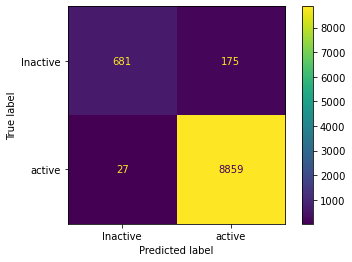

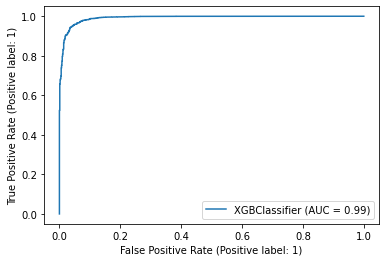

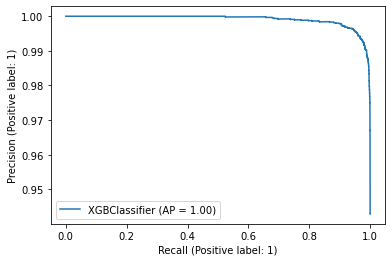

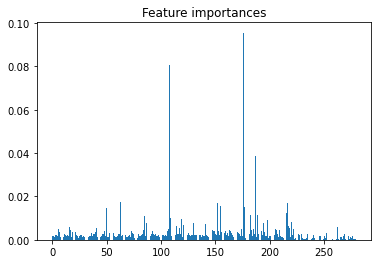

In [ ]:
#with prop_data
print(xgb.score(x,y))
scores=relevant_info(xgb,x_test,y_label_test)

xgb_roc_disp = plot_roc_curve(xgb, x_test, y_label_test)
xgb_pr_disp = plot_precision_recall_curve(xgb, x_test, y_label_test)
plt.show()

importances = xgb.feature_importances_
low,high=min(importances),max(importances)
plt.bar(range(len(importances)), importances,align='center')
plt.title("Feature importances")
plt.show()

0.9784678557679969
Acc on test=  0.9627386573598851 Delta=  0.9627386573598851
AUC=  0.9813646137681662        delta_Auc= 0.9813646137681662 
Precision=  0.9618510891947545 delta_prec= 0.9618510891947545 
Recall=  0.9987620976817466    delta recall= 0.9987620976817466 
f1= 0.9799591453652073         delta f1= 0.9799591453652073 
AUCPR= 0.9979775627883617   delta_aucpr= 0.9979775627883617


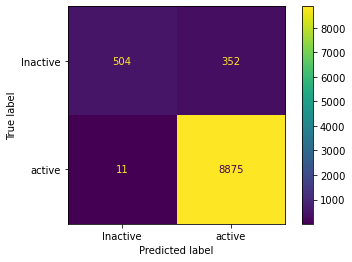

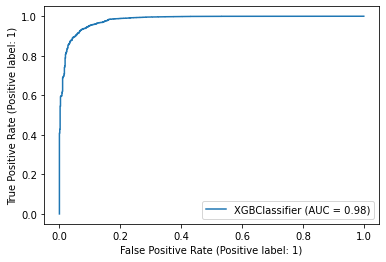

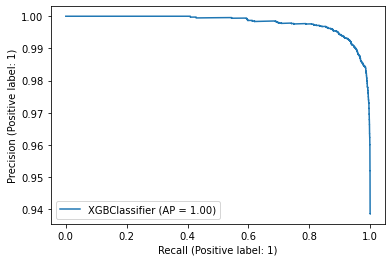

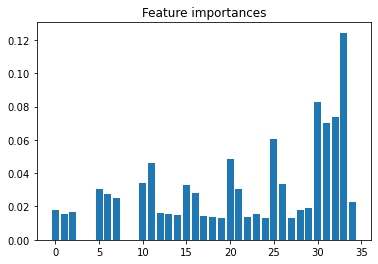

In [ ]:
#without prop_Data
print(xgb.score(x,y))
scores=relevant_info(xgb,x_test,y_label_test)

xgb_roc_disp = plot_roc_curve(xgb, x_test, y_label_test)
xgb_pr_disp = plot_precision_recall_curve(xgb, x_test, y_label_test)
plt.show()

importances = xgb.feature_importances_
low,high=min(importances),max(importances)
plt.bar(range(len(importances)), importances,align='center')
plt.title("Feature importances")
plt.show()

In [ ]:

from numba import njit
def counte(y):    
    s=0
    idx1,idx0=[],[]
    for i in np.arange(len(y)):
        if(y[i]==1.0): 
            s+=1
            idx1.append(i)
        else: idx0.append(i)
    return [idx0,idx1,s]

"""oversample = SMOTE(sampling_strategy=0.01)
under = RandomUnderSampler(sampling_strategy=0.1)
x, y = oversample.fit_resample(x, y)
x, y = under.fit_resample(x, y)"""


"""scaler=StandardScaler().fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
c=counte(y_train)
print('No. of active samples=',c[2])"""


def relevant_info(model,x,y,scorelist=np.zeros(6),aucroc=True): #0=acc,1=auc,2=precision,3=recall,4=f1
    score1=model.score(x, y)
    delta=score1-scorelist[0]
    print('Acc on test= ',score1,'Delta= ',delta)
    pred=model.predict(x)
    pred = np.array([round(value) for value in pred])
    
    if aucroc:
        prob= model.predict_proba(x)[:,1]
        aucc= roc_auc_score(y,prob)
        p,r,th=precision_recall_curve(y,prob)
        aucpr=auc(r,p)
        del_auc= aucc-scorelist[1]
        del_aucpr=aucpr-scorelist[5]
    else: del_auc,aucc,aucpr,del_aucpr=0,0,0,0
    
    prec,recall,f1=precision_score(y,pred),recall_score(y,pred),f1_score(y,pred)
    del_prec,del_recall,del_f1=prec-scorelist[2],recall-scorelist[3],f1-scorelist[4]
    
    print('AUC= ',aucc,'       delta_Auc=',del_auc,'\nPrecision= ',prec,'delta_prec=',del_prec,
          '\nRecall= ',recall,'   delta recall=',del_recall,'\nf1=',f1,'        delta f1=',del_f1,'\nAUCPR=',aucpr,'  delta_aucpr=',del_aucpr)
    plot_confusion_matrix(model,x,y,display_labels=['Inactive','active'])
    plt.show()
    return [score1,aucc,prec,recall,f1,aucpr,aucpr*aucc]


def plot_tree_features(model,n_features):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    plt.title("Feature importances")
    plt.bar(range(n_features), importances,color="r", yerr=std, align="center")
    #plt.xticks(range(x_train.shape[1]), indices)
    plt.xlim([-1, n_features])
    plt.show()

def FP_TP_FN_TN(y_test,y_pred,what='size'):
    y1,y2=y_test.ravel(),y_pred.ravel()
    fp,tp,fn,tn=0,0,0,0
    fpi,tpi,fni,tni=[],[],[],[]
    for i in np.arange(len(y1)):
        a,b=y1[i],y2[i]
        if(a==1): 
            if(b==1):
                tp+=1
                tpi.append(i)
            else:
                fn+=1
                fni.append(i)
        else:
            if(b==1):
                fp+=1
                fpi.append(i)
            else:
                tn+=1
                tni.append(i)
    if(what=='size'):return fp,tp,fn,tn
    elif(what=='indices'): return fpi,tpi,fni,tni
    
@njit
def r_p(y_test,y_prob):
    n=21
    y_test=y_test.ravel()
    y_prob=y_prob.ravel()
    p,r=np.zeros(n),np.zeros(n)
    for i in np.linspace(0,1,n):
        y_pred=np.zeros_like(y_test)
        for j in np.arange(len(y_prob)):
            if y_prob[j]<i :y_pred[j]=0
            else: y_pred[j]=1
        
        y1,y2=y_test,y_pred
        fp,tp,fn,tn=0,0,0,0
        for k in np.arange(len(y1)):
            a,b=y1[k],y2[k]
            if(a==1): 
                if(b==1):tp+=1
                else:fn+=1
            else:
                if(b==1):fp+=1
                else:tn+=1                
        tpr,fpr=(tp/(tp+fn)),(fp/(fp+tn))
        if tp+fp==0: precision=0
        else: precision= tp/(tp+fp)
        recall= tpr
        p[int(i)],r[int(i)]=precision,recall
    return r,p
def calc_aucpr(y_test,y_prob):
    r,p=r_p(y_test,y_prob)
    return auc(r,p)
def results(model,x_train,y_train,x_test,y_test):
    pmodel_test=relevant_info(model,x_test,y_test)
    pmodel_train=relevant_info(model,x_train,y_train)
    return pmodel_test,pmodel_train


# Testing

In [5]:
#load model and scaler
saved_model = tf.keras.models.load_model('saved_model/regressor_best')
ystd = 0.5766398958308416
ymean = -0.5205147113119005
origin_ratio = 0.91309
scaler=load('saved_model/std_scaler.bin')
filt = np.load('saved_model/column_filter.npy')

In [ ]:
#structured by groups in folder called final stable or final unstable
root = 'new_samples/final_unstable'
groups = os.listdir(root)
cif_by_group = []
cif_names_by_group = []
samples_by_group = []
x_samples_by_group = []
preds_by_group = []
results = []

for each in groups:
    
    cif_names = os.listdir(root+'/'+each)
    cifs = []
    for name in cif_names:
        path = root+'/'+each+'/'+name
        f = open(path, "r")
        cifs.append(f.read())

    samples=[]
    for j,i in enumerate(cifs):
        try:
            samples.append(combined_data_from_cifs([i]))
        except: 
            pass
        
    x_samples= np.array(samples).reshape((-1,7,68))
    x_samples = x_samples.reshape((-1,7*68))
    x_samples = scaler.transform(x_samples)
    x_samples = ((x_samples.T[filt]).T)
    
    preds = saved_model.predict(x_samples.reshape((-1,280,1)))*ystd +ymean
    for i in range(len(cif_names)):
        results.append([cif_names[i],preds[i][0],each])
    
    samples_by_group.append(samples)
    cif_by_group.append(cifs)
    cif_names_by_group.append(cif_names)
    x_samples_by_group.append(x_samples)
    preds_by_group.append(preds)

    
predictions = pd.DataFrame(results,columns = ['Compound','predicted_formation_energy','group']).sort_values(by = ['Compound'])
ratioo = -0.05
origin = len(data[data['formation_energy']<ratioo]['formation_energy'])/len(data)
neg_no = (np.array(predictions['predicted_formation_energy'])<ratioo).sum()

print(f'{neg_no} with negative formation energy, ratio = {neg_no/len(results)}')
print(f'{origin} is the original ratio')
print((1-neg_no/len(results))/(1-origin),'times unstable')
predictions

33 with negative formation energy, ratio = 0.6226415094339622
0.8834048494056296 is the original ratio
3.236485296707167 times unstable


,Compound,predicted_formation_energy,group
0,Al2GeAs2.cif,-0.278265,1
1,Al2ZnGeAs.cif,-0.057629,1
2,AlCoCu2Sn.cif,-0.098078,1
3,AlSiSnPb.cif,-0.019393,1
4,AlZnGa2Sn.cif,-0.031029,1
43,BaMnFeRe.cif,0.120042,6
5,BaSrCoRu.cif,0.071881,1
38,BaTaTcW.cif,-0.032603,10
6,BiSbAsRh.cif,-0.228864,1
7,CaCuReSb.cif,-0.210938,1


In [ ]:
# samples in folder new_samples
root = 'new_samples/samples_for_draft'
cif_names = os.listdir(root)
cifs = []
for name in cif_names:
    path = root+'/'+name
    f = open(path, "r")
    cifs.append(f.read())

In [ ]:
cif_names

['AuGaIrSn.cif',
 'BaTaTcW.cif',
 'CaKNiRh.cif',
 'ClF2KMn.cif',
 'HfScSeTi.cif',
 'MoO2SeTi.cif']

In [ ]:
samples=[]
new_cif_names = []
badcifs = []
for j,i in enumerate(cifs):
    try:
        samples.append(combined_data_from_cifs([i]))
        new_cif_names.append(cif_names[j])
    except: 
        badcifs.append([i,cif_names[j]])
        if os.path.exists(root+'/'+cif_names[j]):
            os.remove(root+'/'+cif_names[j])
        

if len(badcifs) != 0:
    pd.DataFrame(badcifs,columns = ['cif','name']).to_csv(root+'/badcifs.csv',index = False)
    
    

In [ ]:
x_samples= np.array(samples).reshape((-1,7,68))
x_samples = x_samples.reshape((-1,7*68))
x_samples = scaler.transform(x_samples)
x_samples = ((x_samples.T[filt]).T)
x_samples.shape

(6, 280)

In [ ]:
preds = saved_model.predict(x_samples.reshape((-1,280,1)))*ystd +ymean
# xgb_preds = xgb.predict(x_samples)

results = []
for i in range(len(new_cif_names)):
    results.append([new_cif_names[i],preds[i][0]])
results

[['AuGaIrSn.cif', -0.3338579],
 ['BaTaTcW.cif', -0.032603234],
 ['CaKNiRh.cif', -0.01597929],
 ['ClF2KMn.cif', -2.2423105],
 ['HfScSeTi.cif', -0.62644625],
 ['MoO2SeTi.cif', -2.2969716]]

In [ ]:
#name, fe model,cgcnn
[['AuGaIrSn.cif', -0.3338579,-0.12863397598266602],
 ['BaTaTcW.cif', -0.032603234,-0.05487599968910217],
 ['CaKNiRh.cif', -0.01597929,0.04799884557723999],
 ['ClF2KMn.cif', -2.2423105,-2.5111775398254395],
 ['HfScSeTi.cif', -0.62644625,-0.7839484214782715],
 ['MoO2SeTi.cif', -2.2969716,-2.096658945083618]]


In [ ]:
predictions = pd.DataFrame(results,columns = ['Compound','predicted_formation_energy']).sort_values(by = ['predicted_formation_energy'])
neg_no = (np.array(predictions['predicted_formation_energy'])<-0.05).sum()
print(f'{neg_no} with negative formation energy, ratio = {neg_no/len(new_cif_names)}')
print(f'{origin_ratio_005} is the original ratio')
print(f'{len(cif_names)-len(new_cif_names)}/{len(cif_names)} bad cifs')
predictions

44 with negative formation energy, ratio = 0.4782608695652174
0.8834048494056296 is the original ratio
0/92 bad cifs


,Compound,predicted_formation_energy
23,Br2Cr1Mn1_4.cif,-0.669106
78,Ir1Mn1Sc1Ti1_4.cif,-0.584798
13,As1Ca1Ni1Sr1_4.cif,-0.566325
88,Se1Ta1Ti1V1_4.cif,-0.557245
67,Ge1In1Y1_3.cif,-0.553700
28,Ca1Ga1Ir1_3.cif,-0.473501
82,Na3Sb1_4.cif,-0.468417
16,As1H1K1Rh1Sn1_5.cif,-0.450138
58,Fe1Ni1Rh1Sc1_4.cif,-0.443847
86,Sc1Sn1W1Zr1_4.cif,-0.407116


In [ ]:
predictions.to_csv('new_samples/formation_energies_unstable_cvae_1.csv',index = False)

In [ ]:
np.abs(np.array(mp_data['formation_energy_per_atom'] ) - preds.flatten()).mean()

0.06758693495433254

In [ ]:
np.array(mp_data['formation_energy_per_atom'] ) - preds.flatten()

array([-0.01833338,  0.0115767 ,  0.07945977, ..., -0.01403415,
       -0.05206539, -0.03823824])

# CGCNN

In [ ]:
# samples in folder new_samples
root = r'cgcnn\data\Generated\new_samples_unstable_cvae_1'
cif_names = os.listdir(root)
cifs = []
for name in cif_names:
    path = root+'/'+name
    f = open(path, "r")
    cifs.append(f.read())

cif_id = [name[:-4] for name in cif_names]
(pd.DataFrame([cif_id,np.arange(len(cifs))]).T).to_csv(root+'\id_prop.csv',index = False)

print(len(cifs))

94


In [ ]:
cif_id = cif_names

In [ ]:
cif_names

['AuGaIrSn.cif',
 'BaTaTcW.cif',
 'CaKNiRh.cif',
 'ClF2KMn.cif',
 'HfScSeTi.cif',
 'MoO2SeTi.cif']

In [ ]:
# Save cifs in a folder
uid = np.arange(len(data))
id_prop = pd.concat([pd.DataFrame(uid,columns = ['id']),data['stability']*10],axis =1 )
id_prop.to_csv('cgcnn/data/OQMD/id_prop.csv',index = False)
# for i in uid:
#     file = open("cifs/"+str(i)+".cif", "w") 
#     file.write(cifs[i])
#     file.close()

#cgcnn mae
# np.abs((pd.read_csv('cgcnn/test_results.csv')['1'] - pd.read_csv('cgcnn/test_results.csv')['2'] )).mean()


In [ ]:
stability = pd.read_csv(r'cgcnn\predictions\new_samples_unstable_cvae_1_stability.csv').sort_values(by=['1'])
formation_e = pd.read_csv(r'new_samples\formation_energies_unstable_cvae_1.csv')
stability['2'] = stability['2']/10
stability

,0,1,2
51,Ag1As1Hg1Sn1_4,0.0,0.103252
18,Ag1As1Sn1_3,1.0,0.001327
79,Ag1Ca1Cu1Ga1Sn1_5,2.0,0.123025
31,Ag1Cu1Mo2_4,3.0,0.103878
49,Ag1Fe1Ru2_4,4.0,0.040894
72,Ag1Pb1Si1Sn1_4,5.0,0.129978
74,Ag1Re1Rh1Sb1_4,6.0,0.009369
52,Ag2Al1Ga1Sn1_5,7.0,0.071603
47,Al1Cu2Ge1Sc1_5,8.0,0.018954
90,Al1In1Sn1Y1_4,9.0,0.096482


In [ ]:
formation_e = formation_e.sort_values('Compound')
stability = stability.sort_values('0')

In [ ]:
#check ordering
names = np.array([i[:-4] for i in np.array(formation_e['Compound'])])
print((names == np.array(stability['0'])).sum(),'out of',len(names))

92 out of 92


In [ ]:
combined_results = pd.concat([formation_e,stability['2']],axis = 1)
combined_results = combined_results.sort_values('predicted_formation_energy')
combined_results = combined_results.rename(columns = {'2':'stability'})
combined_results

,Compound,predicted_formation_energy,stability
0,Br2Cr1Mn1_4.cif,-0.669106,0.116987
1,Ir1Mn1Sc1Ti1_4.cif,-0.584798,0.087257
2,As1Ca1Ni1Sr1_4.cif,-0.566325,0.023092
3,Se1Ta1Ti1V1_4.cif,-0.557245,0.084763
4,Ge1In1Y1_3.cif,-0.553700,0.076508
5,Ca1Ga1Ir1_3.cif,-0.473501,0.033665
6,Na3Sb1_4.cif,-0.468417,0.116882
7,As1H1K1Rh1Sn1_5.cif,-0.450138,0.035220
8,Fe1Ni1Rh1Sc1_4.cif,-0.443847,0.066308
9,Sc1Sn1W1Zr1_4.cif,-0.407116,0.059156


In [ ]:
filt1 = combined_results['predicted_formation_energy']>0 
filt2 = combined_results['stability']<0.1
filtered_df = combined_results[filt1 & filt2]
filtered_df

,Compound,predicted_formation_energy,stability
53,Tc1Y1_2.cif,0.002209,0.047120
54,Ga1Ge1In2Zn1_5.cif,0.003294,0.047214
56,Fe2Mn1Ni1_4.cif,0.010240,0.085016
57,Ag1As1Hg1Sn1_4.cif,0.010990,0.049338
58,Fe1Mn1Ru1Tc1_4.cif,0.014453,0.084333
59,Sb1Tl1_2.cif,0.016625,-0.010558
60,Cr1Mo1Ru1W1_4.cif,0.021152,0.062851
61,Cd1In1Pb1Sn1_4.cif,0.021611,0.088232
64,Cu1Ni1_2.cif,0.025352,0.013857
65,Co1Mg1_2.cif,0.026472,0.080912


In [ ]:
filtered_df.to_csv('filtered_unstable_results.csv',index = False)

In [ ]:
combined_results['Ag1Ca1F3_5.cif' == combined_results['Compound']]

,Compound,predicted_formation_energy,stability
3,Ag1Ca1F3_5.cif,-2.710782,0.046784


In [ ]:
np.array(combined_results['stability']<0.01).sum()

24

## Post

In [ ]:
unstable = pd.read_csv('filtered_unstable_results.csv')
stable = pd.read_csv('filtered_stable_cvae_1.csv')


In [ ]:
stable = stable[stable['predicted_formation_energy']<-0.5]

In [ ]:
stable

,Compound,predicted_formation_energy,stability
0,Ca1F1_2.cif,-3.313963,0.065810
1,F1Mg1_2.cif,-2.956484,0.011081
2,Ag1Ca1F3_5.cif,-2.710782,0.046784
3,O2V1Zr1_4.cif,-2.685354,0.050017
4,Ga1O2S1Sc1_5.cif,-2.419573,0.097852
5,Al1Br1F2_4.cif,-2.314437,0.082695
6,Ba1N1O2V1_5.cif,-2.257816,0.077491
7,Br1F1Li2_4.cif,-2.219991,0.064906
8,Cl2Sc1_3.cif,-2.195625,0.036300
9,Br1Ca1_2.cif,-1.971786,0.035243


In [ ]:
cif_names = np.array(stable['Compound'])

In [ ]:
# samples in folder new_samples
root = 'new_samples/new_samples_stable_cvae_1'
cifs = []
for name in cif_names:
    path = root+'/'+name
    f = open(path, "r")
    cifs.append(f.read())

In [ ]:
stable['cifs'] = cifs

In [ ]:
stable.to_csv('refiltered_stable_cvae_1_with_cifs.csv',index = False)

In [ ]:
pd.read_csv('refiltered_stable_cvae_1_with_cifs.csv')

,Compound,predicted_formation_energy,stability,cifs
0,Ca1F1_2.cif,-3.313963,0.065810,# generated using pymatgen\ndata_CaF\n_symmetr...
1,F1Mg1_2.cif,-2.956484,0.011081,# generated using pymatgen\ndata_MgF\n_symmetr...
2,Ag1Ca1F3_5.cif,-2.710782,0.046784,# generated using pymatgen\ndata_CaAgF3\n_symm...
3,O2V1Zr1_4.cif,-2.685354,0.050017,# generated using pymatgen\ndata_ZrVO2\n_symme...
4,Ga1O2S1Sc1_5.cif,-2.419573,0.097852,# generated using pymatgen\ndata_ScGaSO2\n_sym...
5,Al1Br1F2_4.cif,-2.314437,0.082695,# generated using pymatgen\ndata_AlBrF2\n_symm...
6,Ba1N1O2V1_5.cif,-2.257816,0.077491,# generated using pymatgen\ndata_BaVNO2\n_symm...
7,Br1F1Li2_4.cif,-2.219991,0.064906,# generated using pymatgen\ndata_Li2BrF\n_symm...
8,Cl2Sc1_3.cif,-2.195625,0.036300,# generated using pymatgen\ndata_ScCl2\n_symme...
9,Br1Ca1_2.cif,-1.971786,0.035243,# generated using pymatgen\ndata_CaBr\n_symmet...


In [ ]:
import shutil
for i in np.array(stable['Compound']):
    dest = "new_samples/refiltered_stable_cvae_1_cifs/"+i
    sc = 'new_samples/new_samples_stable_cvae_1/'+i
    shutil.copy(sc,dest)
